In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import scipy
from sklearn.manifold import MDS
from scipy.stats import pearsonr
from sklearn.metrics import explained_variance_score
import itertools
from scipy.spatial.distance import pdist, squareform

plt.style.use("./style.mplstyle")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from cycler import cycler
blues = ['#00153b', '#001f47', '#002953', '#00335f', '#003e6b', '#004977', '#005484', '#006090', '#006c9d', '#0078aa', '#0884b7', '#228fc3', '#369bd0', '#47a7dc', '#56b2e8', '#64bef5', '#72cbfe', '#81d9ff', '#90e6ff', '#9ef4ff']
reds = ['#35001e', '#44002b', '#520437', '#5e0f42', '#691c4b', '#752756', '#803260', '#8c3d6a', '#974875', '#a35380', '#af5e8b', '#bb6996', '#c774a2', '#d47fad', '#e08bb9', '#ed96c5', '#f8a2d1', '#ffb1e0', '#ffc2f1', '#ffd3ff']
greens = ['#002300', '#002d0a', '#003717', '#004220', '#004c29', '#005833', '#00633d', '#006f48', '#007a52', '#00865d', '#009368', '#039f74', '#21ab7f', '#33b78a', '#43c395', '#51cfa1', '#5edbac', '#6be8b8', '#78f4c4', '#8effd8']

odours = ['#009e73', '#51aa6d', '#78b667', '#b6cd57', '#d3d84d', '#efe440']

ModuleNotFoundError: No module named 'sklearn'

# Figure 1

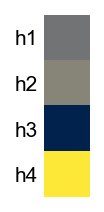

In [2]:
np.random.seed(2)
xs = np.random.normal(0., 1., (4, 1))

fig, ax = plt.subplots(figsize=(1.3, 1.3))
ax.matshow(xs)
ax.set_yticks(range(4))
ax.set_xticks([])
ax.set_yticklabels(["h1", "h2", "h3", "h4"])
ax.spines[["bottom", "left"]].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

fig.savefig("./figures/figure-1-c.svg")

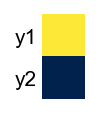

In [3]:
np.random.seed(1)
xs = np.random.normal(0., 1., (2, 1))

fig, ax = plt.subplots(figsize=(1.3/2, 1.3/2))
ax.matshow(xs)
ax.set_yticks(range(2))
ax.set_xticks([])
ax.set_yticklabels(["y1", "y2"])
ax.spines[["bottom", "left"]].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)

fig.savefig("./figures/figure-1-c-2.svg")

# Figure 2

In [4]:
def compact_svd(x):
    u, s, vt = np.linalg.svd(x, False)
    u = u[:, s > 1e-9]
    v = vt.T[:, s > 1e-9]
    s = np.diag(s[s > 1e-9])
    return u, s, v

In [43]:
np.random.seed(1)
in_dim = 12
items_n = in_dim-2
hidden_dim = 20
out_dim = 9

steps = 500

#xs = np.random.normal(0., .5, (in_dim, in_dim-2))
xs = np.vstack([
    np.identity(in_dim-2),
    np.zeros((2, in_dim-2))
])

w1 = np.random.normal(0., 1. / np.sqrt(in_dim), (hidden_dim, in_dim))
w2 = np.random.normal(0., 1. / np.sqrt(hidden_dim), (out_dim, hidden_dim))
w2_transfer = w2[-1, :].copy()
w2 = w2[:out_dim-1, :].copy()

ys = w2 @ w1 @ xs
ys_transfer = w2_transfer @ w1 @ xs

out_dim = out_dim - 1

w2t = w2.copy()
w1t = w1.copy()

In [44]:
np.std(w2 @ w1)

np.float64(0.2997559245120546)

In [45]:
1. / np.sqrt(in_dim)

np.float64(0.2886751345948129)

In [18]:
# Diffusion on linear solution
np.random.seed(1)

w1 = np.random.normal(0., 1. / np.sqrt(in_dim), (hidden_dim, in_dim))
w2 = np.random.normal(0., 1. / np.sqrt(hidden_dim), (out_dim, hidden_dim))

alpha = 0.0125

w1s = []
w2s = []
hs = []
for i in range(steps*2 - 1):
    w1 = (1. - alpha) * w1 + alpha * np.random.normal(0., 5., w1.shape)
    w2 = (1. - alpha) * w2 + alpha * np.random.normal(0., 5., w2.shape)
    for _ in range(3000):
        w2 = w2 - 0.01 * (w2 @ w1 @ xs - ys) @ xs.T @ w1.T
    
    if i >= steps - 1:
        w1s.append(w1)
        hs.append(w1 @ xs)
        w2s.append(w2)

w1s1 = np.asarray(w1s)
hs1 = np.asarray(hs)
w2s1 = np.asarray(w2s)

In [19]:
# Diffusion on least squares solution manifold
np.random.seed(2)

w1 = np.random.normal(0., 1. / np.sqrt(in_dim), (hidden_dim, in_dim))
w2 = np.random.normal(0., 1. / np.sqrt(hidden_dim), (out_dim, hidden_dim))

g, _, _ = compact_svd(xs @ xs.T)

sigyx = ys @ xs.T
sigxx = xs @ xs.T

w1s = []
w2s = []
hs = []
ns = []

for i in range(steps*2 - 1):
    w1 = (1. - alpha) * w1 + alpha * np.random.normal(0., 5., w1.shape)
    w2 = (1. - alpha) * w2 + alpha * np.random.normal(0., 5., w2.shape)
    
    w1 = w1 @ (g @ g.T)
    for _ in range(5000):
        w2 = w2 - 0.012 * (w2 @ w1 @ sigxx - sigyx) @ w1.T
    
    if i >= steps - 1:
        w1s.append(w1)
        hs.append(w1 @ xs)
        w2s.append(w2)

w1s2 = np.asarray(w1s)
hs2 = np.asarray(hs)
w2s2 = np.asarray(w2s)

In [20]:
# Diffusion on minimum-norm solution
np.random.seed(1)

alpha = 0.0125

u_, s_, v_ = compact_svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))
r_ = np.random.normal(0., 1., (hidden_dim, 8))

w1s = []
w2s = []
hs = []
eta = 0.1
for i in range(steps*2 - 1):
    r_ = (1. - alpha) * r_ + alpha * np.random.normal(0., 6., r_.shape)
    r1, _, r2 = np.linalg.svd(r_, False)
    r = r1 @ r2
    w1 = r @ np.sqrt(s_) @ v_.T
    w2 = u_ @ np.sqrt(s_) @ r.T
    
    if i >= steps - 1:
        w1s.append(w1)
        hs.append(w1 @ xs)
        w2s.append(w2)

w1s3 = np.asarray(w1s)
hs3 = np.asarray(hs)
w2s3 = np.asarray(w2s)

In [21]:
# Input noise
s1 = .5
ns = 5000
input_noise = []
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    res = []
    fs = np.einsum("toh,thi->toi", w2s, w1s)
    for t in range(steps):
        losses = []
        xs_ = xs[:, :, None] + np.random.normal(0., np.sqrt(s1), xs.shape + (ns, ))
        ys_ = np.einsum("oi,ibn->obn", fs[t], xs_)
        res.append(0.5 * np.mean(np.linalg.norm(ys_ - ys[:, :, None], axis=0)**2))
    input_noise.append(res)

In [22]:
# Parameter noise
s1 = 0.015
s2 = 0.075
ns = 1000
parameter_noise = []
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    res = []
    for t in range(steps):
        losses = []
        w1s_ = w1s[t, :, :, None] + np.random.normal(0., np.sqrt(s1), w1s.shape[1:] + (ns, ))
        w2s_ = w2s[t, :, :, None] + np.random.normal(0., np.sqrt(s2), w2s.shape[1:] + (ns, ))
        fs = np.einsum("ohn,hin->oin", w2s_, w1s_)
        ys_ = np.einsum("oin,ib->obn", fs, xs)
        res.append(0.5 * np.mean(np.linalg.norm(ys_ - ys[:, :, None], axis=0)**2))
    parameter_noise.append(res)

(3, 7)
-1.9137507053640763 5.558558278126398
-1.4363523291684535 4.285697968915461
-0.2893618664565829 0.9667976121807997


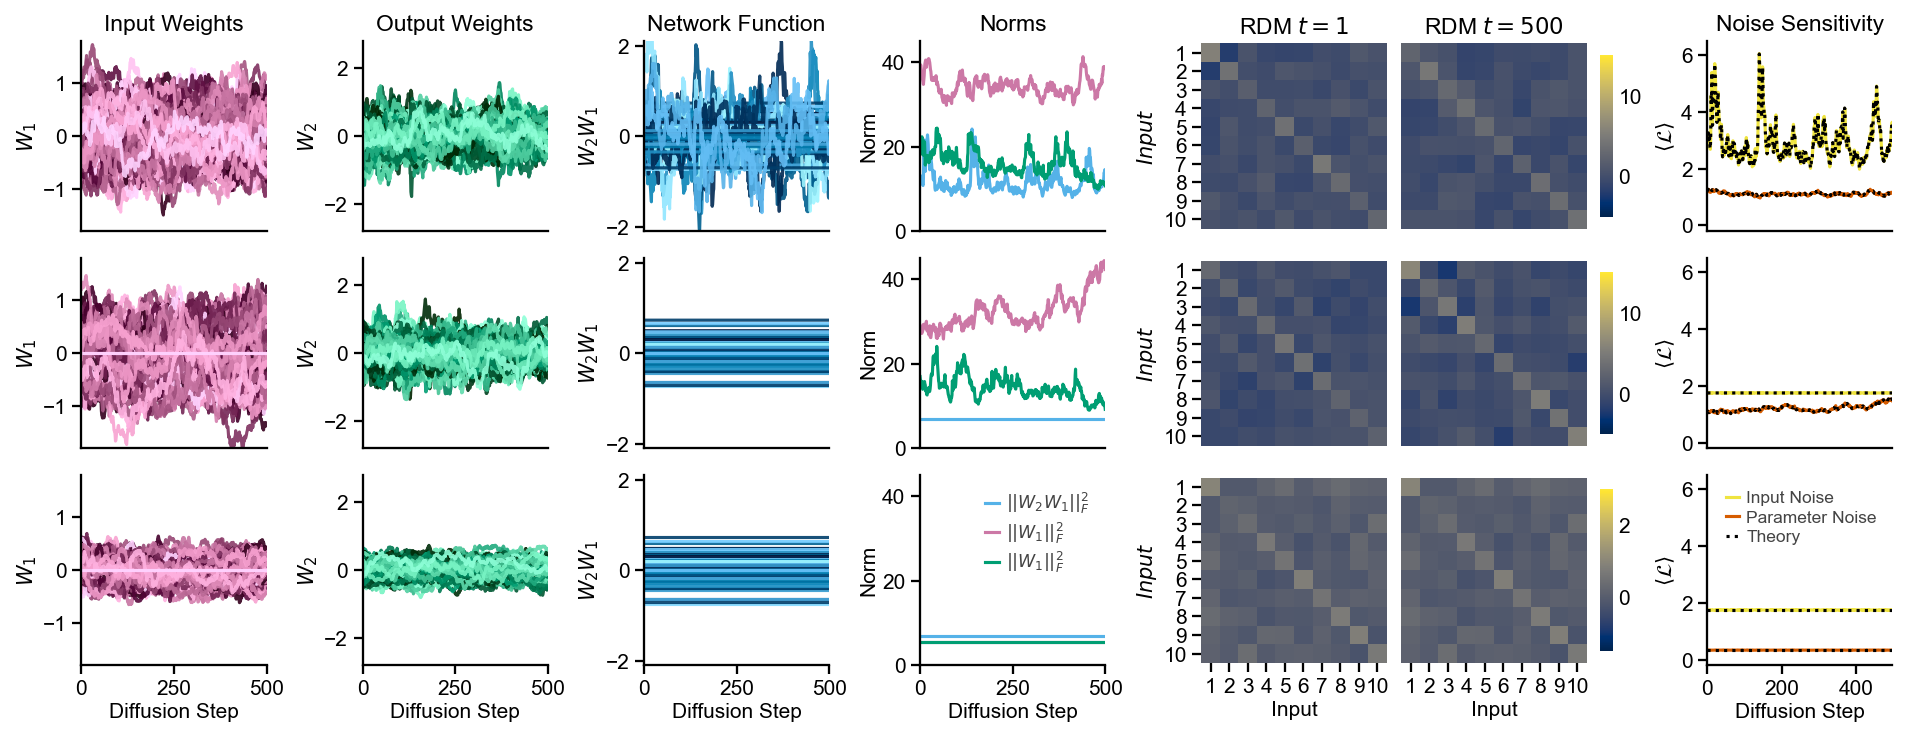

In [23]:
fig, axs = plt.subplots(3, 7, figsize=(1.8*7, 1.6*3))
print(axs.shape)
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    axs_ = axs[i]

    # Input weights
    ax = axs_[0]
    ax.set_prop_cycle(cycler(color=reds))
    ax.plot(w1s.reshape(steps, -1), alpha=0.9)

    ax.set_ylim(-1.8, 1.8)
    if i == 0:
        ax.set_title("Input Weights")
    if i == 2:
        ax.set_xlabel("Diffusion Step")
    ax.set_ylabel("$W_1$")

    # Output weights
    ax = axs_[1]
    ax.set_prop_cycle(cycler(color=greens))
    ax.plot(w2s.reshape(steps, -1), alpha=0.9)

    ax.set_ylim(-2.8, 2.8)
    if i == 0:
        ax.set_title("Output Weights")
    if i == 2:
        ax.set_xlabel("Diffusion Step")
    ax.set_ylabel("$W_2$")

    # Network function
    ax = axs_[2]
    ax.set_prop_cycle(cycler(color=blues))
    f = np.einsum("abc,adb->adc", w1s, w2s)
    ax.plot(f.reshape(steps, -1), alpha=0.9)
    
    ax.set_ylim(-2.1, 2.1)
    if i == 0:
        ax.set_title("Network Function")
    if i == 2:
        ax.set_xlabel("Diffusion Step")
    ax.set_ylabel("$W_2W_1$")
    
    # Norms
    ax = axs_[3]
    network_norm = np.linalg.norm(np.einsum("abc,adb->adc", w1s, w2s), ord="fro", axis=(1,2))**2
    ax.plot(network_norm, label="$||W_2W_1||_F^2$")
    w1_norm = np.linalg.norm(w1s, ord="fro", axis=(1,2))**2
    w2_norm = np.linalg.norm(w2s, ord="fro", axis=(1,2))**2
    
    ax.plot(w1_norm - 1, label="$||W_1||_F^2$")
    ax.plot(w2_norm - 1, label="$||W_1||_F^2$")
    
    # ax.set_ylim(-2, 50)
    ax.set_ylabel("Norm")
    if i == 2:
        leg = ax.legend(loc=[0., 0.5], fontsize=7., facecolor="white", framealpha=0.8, frameon=False)
        leg.get_frame().set_linewidth(0.0)
    if i == 0:
        ax.set_title("Norms")
    if i == 2:
        ax.set_xlabel("Diffusion Step")
        ax.legend()
    ax.set_ylim(0., 45)

    for j in range(4):
        ax = axs_[j]
        if i == 2:
            ax.set_xticks([0, 250, 500])
        else:
            ax.set_xticks([])

    # Hidden layer representation t=0
    if i != 2:
        vmin = -5
        vmax = 15
    else:
        vmin = -1.5
        vmax = 3.
        
    ax = axs_[4]
    h = xs.T @ w1s[0].T @ w1s[0] @ xs
    print(np.min(h), np.max(h))
    ax.imshow(h, vmin=vmin, vmax=vmax)

    if i == 0:
        ax.set_title("RDM $t=1$")
    if i == 2:
        ax.set_xlabel("Input")
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
    else:
        ax.set_xticks([])
    ax.set_yticks(range(10))
    ax.set_yticklabels(range(1, 11))
    ax.set_ylabel("$Input$")

    ax.spines[["bottom", "left"]].set_visible(False)
    
    # Hidden layer representation t=500 
    ax = axs_[5]
    h = xs.T @ w1s[-1].T @ w1s[-1] @ xs
    cbax = ax.imshow(h, vmin=vmin, vmax=vmax)

    if i == 0:
        ax.set_title("RDM $t=500$")
    if i == 2:
        ax.set_xlabel("Input")
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["bottom", "left"]].set_visible(False)

    cb = fig.colorbar(cbax, shrink=0.85, aspect=12, pad=0.06, ax=ax)
    cb.outline.set_visible(False)
    #cb.set_ticks([vmin, vmax])
    cb.ax.tick_params(length=0)

    # Noise
    ax = axs_[6]
    if i == 0:
        ax.set_title("Noise Sensitivity")
    if i == 2:
        ax.set_xlabel("Diffusion Step")
        ax.set_xticks([0, 200, 400])
    else:
        ax.set_xticks([])
    ax.set_ylabel("$\langle\mathcal{L}\\rangle$")
        
    sigxx = 1. / items_n * xs @ xs.T
    sigyx = 1. / items_n * ys @ xs.T
    sigyy = 1. / items_n * ys @ ys.T
    
    ax.plot(input_noise[i], label="Input Noise", c=colors[3])
    ax.plot(parameter_noise[i], label="Parameter Noise", c=colors[4])

    s1 = .5
    f = np.einsum("abc,adb->adc", w1s, w2s)
    c = 0.5 * np.trace(sigyy) - 0.5 * np.trace(sigyx @ np.linalg.pinv(sigxx) @ sigyx.T)
    theory = (s1 / 2.) * np.linalg.norm(f, axis=(1, 2), ord="fro")**2 + c
    ax.plot(theory, c="k", linestyle="dotted", label="Theory")
    ax.set_ylim(-0.2, 7.3)
    
    s1 = 0.015
    s2 = 0.075
    
    ax.set_ylim(-0.2, 6.5)

    c = 0.5 * np.trace(sigyy) - 0.5 * np.trace(sigyx @ np.linalg.pinv(sigxx) @ sigyx.T)
    t1 = s1 * np.linalg.norm(w2s, axis=(1, 2))**2 * np.trace(sigxx)
    t2 = out_dim * s2 * np.trace(np.einsum("tad,dc->tac", np.einsum("abt,tbd->tad", w1s.T, w1s), sigxx), axis1=1, axis2=2)
    t3 = hidden_dim * s1 * out_dim * s2 * np.trace(sigxx)
    
    theory = 0.5 * (t1 + t2 + t3) + c
    ax.plot(theory, c="k", linestyle="dotted")

    if i == 2:
        ax.legend()

fig.savefig("./figures/figure-2-a.svg")

# Representational similarity

In [24]:
hss = [hs1, hs2, hs3]
rss = []
pss = []
for pair in [(1, 0), (1, 2)]: # itertools.combinations(range(3), 2):
    h1 = hss[pair[0]]
    h2 = hss[pair[1]]

    euclidean_1 = np.asarray([squareform(pdist(h.T, metric='euclidean')) for h in h1])
    euclidean_2 = np.asarray([squareform(pdist(h.T, metric='euclidean')) for h in h2])
    
    e1s = [e1[~np.eye(e1.shape[0], dtype=bool)] for e1 in euclidean_1]
    e2s = [e1[~np.eye(e1.shape[0], dtype=bool)] for e1 in euclidean_2]

    rss.append([pearsonr(e1, e2).statistic for e1, e2 in zip(e1s, e2s)])
    pss.append([pearsonr(e1, e2).pvalue for e1, e2 in zip(e1s, e2s)])

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, explained_variance_score

linear_model = LinearRegression()
hss = [hs1, hs2, hs3]
lms_1 = []
lms_2 = []
r2s = []
for pair in [(1, 2), (2, 1), (1, 1)]: # itertools.combinations(range(3), 2):
    h1s = hss[pair[0]]
    h2s = hss[pair[1]]

    rs = []
    for t in range(steps):
        lm = linear_model.fit(h1s[t], h2s[t]).predict(h1s[t])
        rs.append(r2_score(h2s[t], lm))
    r2s.append(rs)

In [30]:
drs = []
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    w1 = w1s[0]
    w2 = ys @ xs.T @ w1.T @ np.linalg.pinv(w1 @ xs @ xs.T @ w1.T)
    loss = []
    for t in range(steps):
        loss.append(0.5 * 1. / items_n * np.linalg.norm(w2 @ w1s[t] @ xs - ys)**2)
    drs.append(loss)

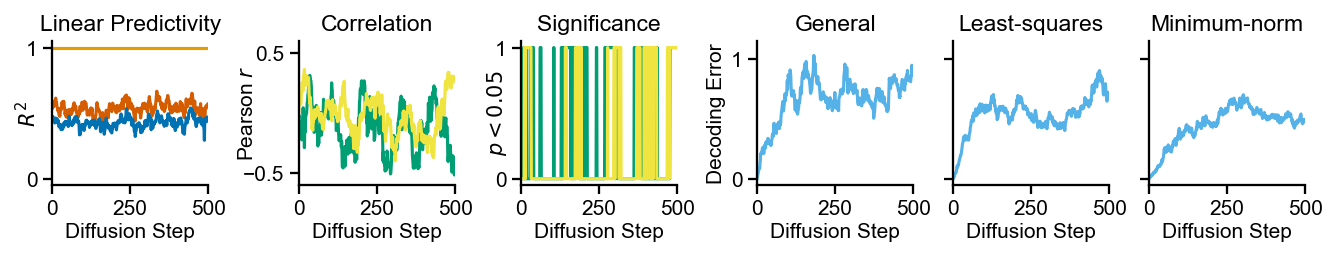

In [42]:
fig, axs = plt.subplots(1, 6, figsize=(1.6*5.5, 1.6))
ax = axs[0]
for i, rs in enumerate(r2s):
    ax.plot(np.asarray(rs), c=colors[i+4])
ax.set_title("Linear Predictivity")
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel("$R^2$", labelpad=-7)
ax.set_xlabel("Diffusion Step")
ax.set_xticks([0, 250, 500])
ax.set_yticks([0, 1])

for i, (rs, ps) in enumerate(zip(rss, pss)):
    ax = axs[1]
    ax.plot(rs, c=colors[i+2])
    ax.set_ylim(-0.6, .6)
    ax.set_ylabel("Pearson $r$", labelpad=-7)
    ax.set_title("Correlation")
    ax.set_xlabel("Diffusion Step")
    ax.set_xticks([0, 250, 500])
    ax.set_yticks([-0.5, 0.5])
    
    ax = axs[2]
    ax.plot(np.asarray(ps) < 0.05, c=colors[i+2])
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("$p < 0.05$", labelpad=-7)
    ax.set_title("Significance")
    ax.set_xlabel("Diffusion Step")
    ax.set_xticks([0, 250, 500])
    ax.set_yticks([0, 1])

for j, t in enumerate(["General", "Least-squares", "Minimum-norm"]):
    ax = axs[j+3]
    ax.plot(drs[j])
    ax.set_ylim(-0.05, 1.15)
    ax.set_yticks([0, 1])
    ax.set_yticklabels([])
    if j == 0:
        ax.set_yticklabels([0, 1])
        ax.set_ylabel("Decoding Error")
    ax.set_title(t)
    ax.set_xlabel("Diffusion Step")
    ax.set_xticks([0, 250, 500])

fig.savefig("./figures/figure-4.svg")

In [43]:
pearsonr([0, 2, 8], [1, 3, 8])

PearsonRResult(statistic=np.float64(0.999260081289737), pvalue=np.float64(0.024491416710799036))

In [17]:
pdist(h1, metric='euclidean', axis=(1, 2)).shape

ValueError: A 2-dimensional array must be passed.

In [ ]:

for i in range(3):
    for j in range(3):
        h1 = np.einsum("thi,in-thn", w1s, xs)
        h1 = np.einsum("thi,in-thn", w1s, xs)

rdm_nn = squareform(pdist(hs.T, metric='euclidean'))

# Classification

Text(0.5, 1.0, '${\\bf Y}$')

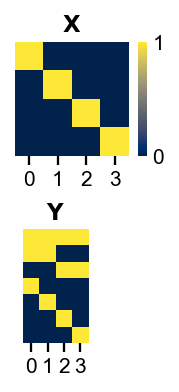

In [54]:
xs = np.identity(4)
ys = np.asarray([
    [1., 1., 1., 1.],
    [1., 1., 0., 0.],
    [0., 0., 1., 1.],
    [1., 0., 0., 0.],
    [0., 1., 0., 0.],
    [0., 0., 1., 0.],
    [0., 0., 0., 1.]
])

fig, axs = plt.subplots(2, 1, figsize=(1.3, 2.5))
cbax = axs[0].imshow(xs, vmin=0., vmax=1.)
axs[1].imshow(ys, vmin=0., vmax=1.)

for i in range(2):
    ax = axs[i]
    ax.spines[["bottom", "left"]].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks(range(4))

cb = fig.colorbar(cbax, shrink=1., aspect=12, pad=0.06, ax=axs[0])
cb.outline.set_visible(False)
cb.set_ticks([0, 1])
cb.ax.tick_params(length=0)

axs[0].set_title("${\\bf X}$")
axs[1].set_title("${\\bf Y}$")

In [57]:
in_dim = 4
out_dim = 7

w1 = np.random.normal(0., 1. / np.sqrt(in_dim), (hidden_dim, in_dim))
w2 = np.random.normal(0., 1. / np.sqrt(hidden_dim), (out_dim, hidden_dim))

for _ in range(5000):
    w2 = w2 - 0.01 * (w2 @ w1 @ xs - ys) @ xs.T @ w1.T

In [ ]:
fig, axs = plt.subplots(1, 3)
for i in range(3):
    ax = axs[i]
    
    ax.mathsow()

In [17]:
np.random.seed(1)
a = np.random.normal(0., 1., (3, 1))
b = np.random.normal(0., 1., (3, 1))

res = 0.
for i in range(3):
    res += (a[i] - b[i])**2
print(np.sqrt(res))

[3.5499784]


In [18]:
np.linalg.norm(a - b)

np.float64(3.5499784039081344)

(3, 4)
-6.285911461897806 14.137757318397844
-4.260332354509411 14.562919897031612
-1.3914418492459457 3.2616932176115627


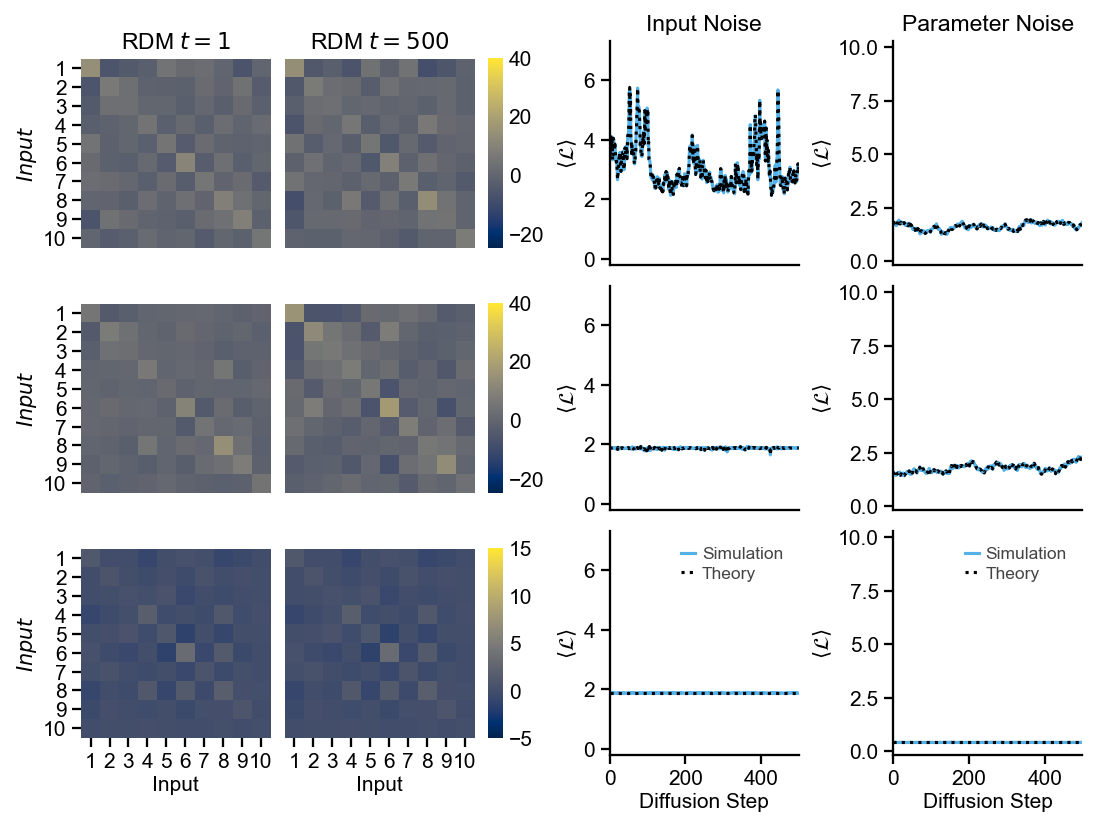

In [126]:
fig, axs = plt.subplots(3, 4, figsize=(1.8*4, 1.8*3))
print(axs.shape)
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    axs_ = axs[i]

    if i != 2:
        vmin = -25
        vmax = 40
    else:
        vmin = -5
        vmax = 15
    # Hidden layer representation t=0 
    ax = axs_[0]
    h = xs.T @ w1s[0].T @ w1s[0] @ xs
    print(np.min(h), np.max(h))
    ax.imshow(h, vmin=vmin, vmax=vmax)

    if i == 0:
        ax.set_title("RDM $t=1$")
    if i == 2:
        ax.set_xlabel("Input")
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
    else:
        ax.set_xticks([])
    ax.set_yticks(range(10))
    ax.set_yticklabels(range(1, 11))
    ax.set_ylabel("$Input$")

    ax.spines[["bottom", "left"]].set_visible(False)
    
    # Hidden layer representation t=500 
    ax = axs_[1]
    h = xs.T @ w1s[-1].T @ w1s[-1] @ xs
    cbax = ax.imshow(h, vmin=vmin, vmax=vmax)

    if i == 0:
        ax.set_title("RDM $t=500$")
    if i == 2:
        ax.set_xlabel("Input")
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[["bottom", "left"]].set_visible(False)

    cb = fig.colorbar(cbax, shrink=0.85, aspect=12, pad=0.06, ax=ax)
    cb.outline.set_visible(False)
    #cb.set_ticks([vmin, vmax])
    cb.ax.tick_params(length=0)
    
    # Input noise
    ax = axs_[2]
    
    if i == 0:
        ax.set_title("Input Noise")
    if i == 2:
        ax.set_xlabel("Diffusion Step")
        ax.set_xticks([0, 200, 400])
    else:
        ax.set_xticks([])
    ax.set_ylabel("$\langle\mathcal{L}\\rangle$")
        
    sigxx = 1. / items_n * xs @ xs.T
    sigyx = 1. / items_n * ys @ xs.T
    sigyy = 1. / items_n * ys @ ys.T
    
    ax.plot(input_noise[i], label="Simulation")
    s1 = .5
    f = np.einsum("abc,adb->adc", w1s, w2s)
    c = 0.5 * np.trace(sigyy) - 0.5 * np.trace(sigyx @ np.linalg.pinv(sigxx) @ sigyx.T)
    theory = (s1 / 2.) * np.linalg.norm(f, axis=(1, 2), ord="fro")**2 + c
    ax.plot(theory, c="k", linestyle="dotted", label="Theory")
    ax.set_ylim(-0.2, 7.3)

    if i == 2:
        ax.legend()


    # Parameter noise
    ax = axs_[3]
    
    if i == 0:
        ax.set_title("Parameter Noise")
    if i == 2:
        ax.set_xlabel("Diffusion Step")
        ax.set_xticks([0, 200, 400])
    else:
        ax.set_xticks([])
    ax.set_ylabel("$\langle\mathcal{L}\\rangle$")
        
    sigxx = 1. / items_n * xs @ xs.T
    sigyx = 1. / items_n * ys @ xs.T
    sigyy = 1. / items_n * ys @ ys.T
    
    ax.plot(parameter_noise[i], label="Simulation")
    s1 = 0.01
    s2 = 0.05
    
    ax.set_ylim(-0.2, 10.3)

    c = 0.5 * np.trace(sigyy) - 0.5 * np.trace(sigyx @ np.linalg.pinv(sigxx) @ sigyx.T)
    t1 = s1 * np.linalg.norm(w2s, axis=(1, 2))**2 * np.trace(sigxx)
    t2 = out_dim * s2 * np.trace(np.einsum("tad,dc->tac", np.einsum("abt,tbd->tad", w1s.T, w1s), sigxx), axis1=1, axis2=2)
    t3 = hidden_dim * s1 * out_dim * s2 * np.trace(sigxx)
    
    theory = 0.5 * (t1 + t2 + t3) + c
    ax.plot(theory, c="k", linestyle="dotted", label="Theory")

    if i == 2:
        ax.legend()
    

### Norms

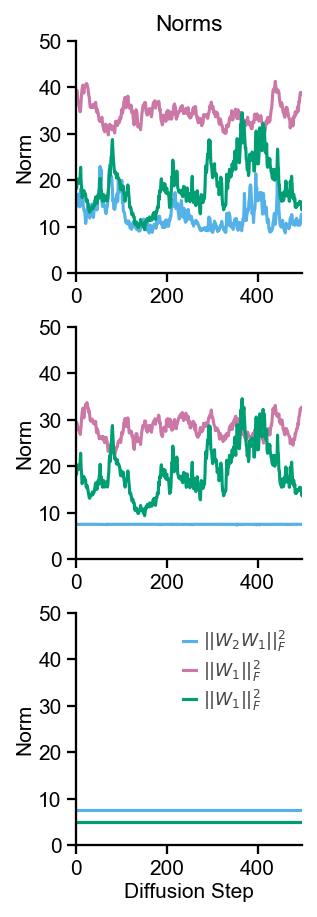

In [170]:
fig, axs = plt.subplots(3, 1, figsize=(2, 6))
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    ax = axs[i]
    network_norm = np.linalg.norm(np.einsum("abc,adb->adc", w1s, w2s), ord="fro", axis=(1,2))**2
    ax.plot(network_norm, label="$||W_2W_1||_F^2$")
    w1_norm = np.linalg.norm(w1s, ord="fro", axis=(1,2))**2
    w2_norm = np.linalg.norm(w2s, ord="fro", axis=(1,2))**2
    
    ax.plot(w1_norm - 1, label="$||W_1||_F^2$")
    ax.plot(w2_norm - 1, label="$||W_1||_F^2$")
    
    # ax.set_ylim(-2, 50)
    ax.set_ylabel("Norm")
    if i == 2:
        leg = ax.legend(loc=[0., 0.5], fontsize=7., facecolor="white", framealpha=0.8, frameon=False)
        leg.get_frame().set_linewidth(0.0)
    if i == 0:
        ax.set_title("Norms")
    if i == 2:
        ax.set_xlabel("Diffusion Step")
        ax.legend()
    ax.set_ylim(0., 50)

## Input noise

In [70]:
s1 = .5
ns = 5000
ress = []
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    res = []
    fs = np.einsum("toh,thi->toi", w2s, w1s)
    for t in range(steps):
        losses = []
        xs_ = xs[:, :, None] + np.random.normal(0., np.sqrt(s1), xs.shape + (ns, ))
        ys_ = np.einsum("oi,ibn->obn", fs[t], xs_)
        res.append(0.5 * np.mean(np.linalg.norm(ys_ - ys[:, :, None], axis=0)**2))
    ress.append(res)

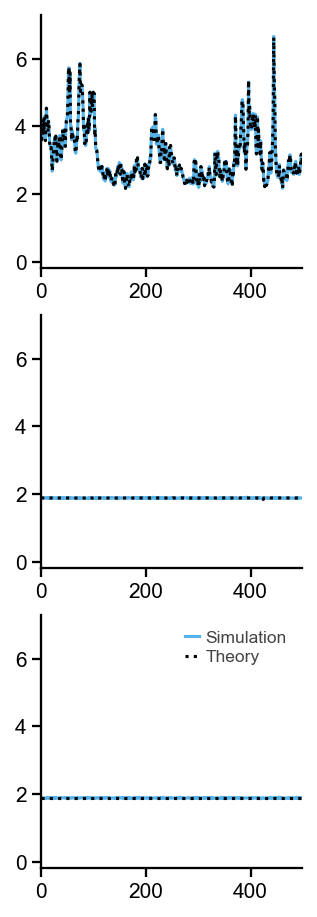

In [71]:
sigxx = 1. / items_n * xs @ xs.T
sigyx = 1. / items_n * ys @ xs.T
sigyy = 1. / items_n * ys @ ys.T

fig, axs = plt.subplots(3, 1, figsize=(2, 6))
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    ax = axs[i]
    ax.plot(ress[i], label="Simulation")
    f = np.einsum("abc,adb->adc", w1s, w2s)
    c = 0.5 * np.trace(sigyy) - 0.5 * np.trace(sigyx @ np.linalg.pinv(sigxx) @ sigyx.T)
    theory = (s1 / 2.) * np.linalg.norm(f, axis=(1, 2), ord="fro")**2 + c
    ax.plot(theory, c="k", linestyle="dotted", label="Theory")
    ax.set_ylim(-0.2, 7.3)

axs[2].legend()

## Parameter Noise

In [278]:
s1 = 0.01
s2 = 0.05
ns = 1000
ress = []
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    res = []
    for t in range(steps):
        losses = []
        w1s_ = w1s[t, :, :, None] + np.random.normal(0., np.sqrt(s1), w1s.shape[1:] + (ns, ))
        w2s_ = w2s[t, :, :, None] + np.random.normal(0., np.sqrt(s2), w2s.shape[1:] + (ns, ))
        fs = np.einsum("ohn,hin->oin", w2s_, w1s_)
        ys_ = np.einsum("oin,ib->obn", fs, xs)
        res.append(0.5 * np.mean(np.linalg.norm(ys_ - ys[:, :, None], axis=0)**2))
    ress.append(res)

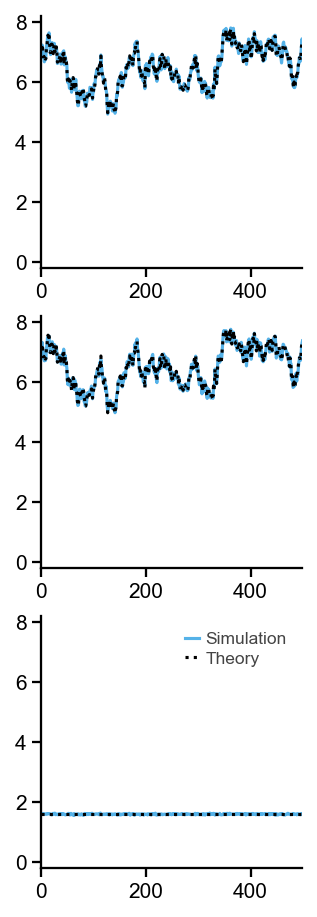

In [279]:
sigxx = 1. / items_n * xs @ xs.T
sigyx = 1. / items_n * ys @ xs.T
sigyy = 1. / items_n * ys @ ys.T

fig, axs = plt.subplots(3, 1, figsize=(2, 6))
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    ax = axs[i]
    ax.plot(ress[i], label="Simulation")
    c = 0.5 * np.trace(sigyy) - 0.5 * np.trace(sigyx @ np.linalg.pinv(sigxx) @ sigyx.T)
    t1 = s1 * np.linalg.norm(w2s, axis=(1, 2))**2 * np.trace(sigxx)
    t2s = []
    #for t in range(steps):
    #    t2s.append(out_dim * s2 * np.trace(w1s[t].T @ w1s[t] @ sigxx))
    #t2 = np.asarray(t2s)
    t2 = out_dim * s2 * np.trace(np.einsum("tad,dc->tac", np.einsum("abt,tbd->tad", w1s.T, w1s), sigxx), axis1=1, axis2=2)
    t3 = hidden_dim * s1 * out_dim * s2 * np.trace(sigxx)
    
    theory = 0.5 * (t1 + t2 + t3) + c
    ax.plot(theory, c="k", linestyle="dotted", label="Theory")
    ax.set_ylim(-0.2, 8.2)
axs[2].legend()

## Generalisation

In [292]:
w1s.shape, w2s.shape, xs_.shape

((500, 20, 12), (500, 8, 20), (12, 2))

In [305]:
gen_losses = []
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    res = []
    u, s, vt = np.linalg.svd(xs)
    xs_ = u[:, items_n:]
    ys_ = np.einsum("toh,thi,in->ton", w2s, w1s, xs_)
    loss = 0.5 * np.linalg.norm(ys_ - 0, axis=(1, 2))**2
    gen_losses.append(loss)

gen_losses2 = []
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    res = []
    u, s, vt = np.linalg.svd(xs)
    xs_ = u[:, :items_n]
    ys_ = np.einsum("toh,thi,in->ton", w2s, w1s, xs_)
    loss = 0.5 * np.linalg.norm(ys_ - w2t @ w1t @ xs_, axis=(1, 2))**2
    gen_losses2.append(loss)

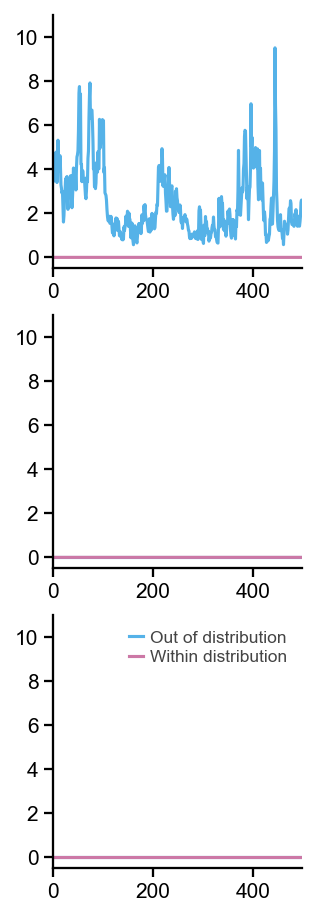

In [306]:
fig, axs = plt.subplots(3, 1, figsize=(2, 6))
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    ax = axs[i]
    ax.plot(gen_losses[i], label="Out of distribution")
    ax.plot(gen_losses2[i], label="Within distribution")
    ax.set_ylim(-.5, 11.)
axs[2].legend()

## Transfer learning

In [314]:

w2_ = ys @ xs.T @ w1.T @ np.linalg.pinv(w1 @ xs @ xs.T @ w1.T)
print(w2_.shape)

(8, 20)


In [254]:
np.round(w1s[t].T @ w1s[t], 2).shape

(12, 12)

In [252]:
w1s[0].T.shape

(12, 20)

In [253]:
w1s[0].shape

(20, 12)

In [257]:
[0]

array([[ 0.77322998, -0.08416988,  0.51220956,  0.18339107, -0.08224119,
        -0.12659733,  0.0205669 ,  0.09499045, -0.32165662,  0.34744338,
         0.2077094 ,  0.1814933 ],
       [-0.08416988,  0.3772084 ,  0.15076011, -0.02365114,  0.15767254,
        -0.41196117, -0.04209893, -0.03860734,  0.00289214, -0.14956949,
        -0.09940406, -0.06744362],
       [ 0.51220956,  0.15076011,  1.06802554,  0.13801042,  0.34280017,
        -0.42669967,  0.15443705,  0.16439717, -0.27952697,  0.20765927,
         0.03399144,  0.04984868],
       [ 0.18339107, -0.02365114,  0.13801042,  0.41568402,  0.14653563,
        -0.05212687,  0.04916397,  0.01578082, -0.22812286, -0.02694204,
         0.05595649,  0.00789455],
       [-0.08224119,  0.15767254,  0.34280017,  0.14653563,  0.70169442,
        -0.28601919,  0.07128747,  0.13669539, -0.04022215, -0.31030759,
         0.256953  , -0.21238239],
       [-0.12659733, -0.41196117, -0.42669967, -0.05212687, -0.28601919,
         0.60785904,  

In [233]:
w1s.shape

(500, 20, 12)

In [237]:
w1s[0].T @ w1s[0]

array([[ 0.77322998, -0.08416988,  0.51220956,  0.18339107, -0.08224119,
        -0.12659733,  0.0205669 ,  0.09499045, -0.32165662,  0.34744338,
         0.2077094 ,  0.1814933 ],
       [-0.08416988,  0.3772084 ,  0.15076011, -0.02365114,  0.15767254,
        -0.41196117, -0.04209893, -0.03860734,  0.00289214, -0.14956949,
        -0.09940406, -0.06744362],
       [ 0.51220956,  0.15076011,  1.06802554,  0.13801042,  0.34280017,
        -0.42669967,  0.15443705,  0.16439717, -0.27952697,  0.20765927,
         0.03399144,  0.04984868],
       [ 0.18339107, -0.02365114,  0.13801042,  0.41568402,  0.14653563,
        -0.05212687,  0.04916397,  0.01578082, -0.22812286, -0.02694204,
         0.05595649,  0.00789455],
       [-0.08224119,  0.15767254,  0.34280017,  0.14653563,  0.70169442,
        -0.28601919,  0.07128747,  0.13669539, -0.04022215, -0.31030759,
         0.256953  , -0.21238239],
       [-0.12659733, -0.41196117, -0.42669967, -0.05212687, -0.28601919,
         0.60785904,  

In [ ]:
w1 = w1s2[-1].copy()
w2 = w2s2[-1].copy()

losses = []
for i in range(15000):
    xi1 = np.random.normal(0., np.sqrt(s1), w1.shape)
    xi2 = np.random.normal(0., np.sqrt(s2), w2.shape)
    losses.append(1. / (2. * items_n) * np.linalg.norm((w2 + xi2) @ (w1 + xi1) @ xs - ys, ord="fro")**2)
print(np.mean(losses))

sigxx = 1. / items_n * xs @ xs.T
t1 = s1 * np.linalg.norm(w2)**2 * np.trace(sigxx)
t2 = out_dim * s2 * np.trace(w1.T @ w1 @ sigxx)
t3 = hidden_dim * s1 * out_dim * s2 * np.trace(sigxx)
print(0.5 * (t1 + t2 + t3))

In [61]:
w1 = np.random.normal(0., 1., (hidden_dim, in_dim))
w2 = np.random.normal(0., 1., (out_dim, hidden_dim))

err = 0.
for i in range(items_n):
    err += (w2 @ w1 @ xs[:, i] - ys[:, i]).T @ (w2 @ w1 @ xs[:, i] - ys[:, i])
print(1. / (2. * items_n) * err)

err = 0.
for i in range(items_n):
    x = xs[:, [i]]
    y = ys[:, [i]]
    t1 = x.T @ w1.T @ w2.T @ w2 @ w1 @ x
    t2 = x.T @ w1.T @ w2.T @ y
    t3 = y.T @ w2 @ w1 @ x
    t4 = y.T @ y
    err += t1 - t2 - t3 + t4
print(1. / (2. * items_n) * err)

sigxx = 1. / items_n * xs @ xs.T
sigyx = 1. / items_n * ys @ xs.T
sigyx = 1. / items_n * ys @ xs.T

print(0.5 * np.trace(w1.T @ w2.T @ w2 @ w1 @ sigxx) - np.trace(w1.T @ w2.T @ sigyx) + 0.5 * np.trace(si


423.63207760981805
[[423.63207761]]


4.170730400820013
3.668075187720557
3.7602556833373186


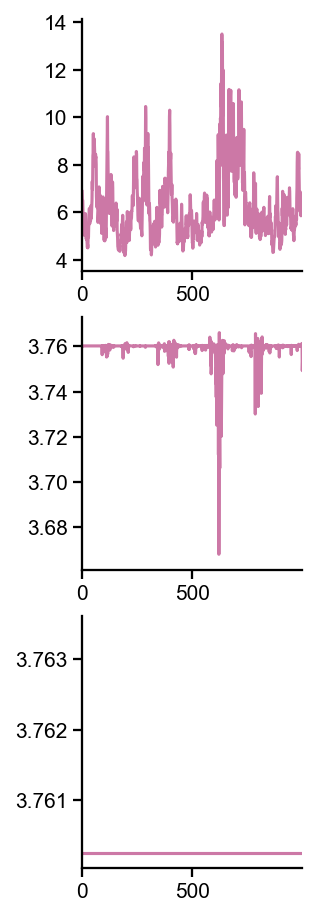

In [55]:
sigxx = 1. / items_n * xs @ xs.T
sigyx = 1. / items_n * ys @ xs.T

fig, axs = plt.subplots(3, 1, figsize=(2, 6))
for i, (w1s, hs, w2s) in enumerate([[w1s1, hs1, w2s1], [w1s2, hs2, w2s2], [w1s3, hs3, w2s3]]):
    ax = axs[i]
    ax.plot(ress[i])
    f = np.einsum("abc,adb->adc", w1s, w2s)
    c = 0.5 * np.trace(sigxx) - 0.5 * np.trace(sigyx @ np.linalg.pinv(sigxx) @ sigyx.T)
    the = (s1 / 2.) * np.linalg.norm(f, axis=(1, 2), ord="fro")**2 # + c
    print(np.min(the))
    ax.plot(the)

In [27]:
t = 200
n = 1500000
xs_ = np.tile(xs[:, :, None], (1, 1, n)) + np.random.normal(0., np.sqrt(s1), (1, 1, n))
ys_ = np.einsum("oi,ibn->obn", f[t], xs_)
# ys_ = f[t] @ (xs + np.random.normal(0., np.sqrt(s1), xs.shape))
print(0.5 * np.mean(np.linalg.norm(ys_ - ys[:, :, None], axis=0)**2))

5.807808297306679


In [28]:
c = 0.5 * np.trace(sigxx) - 0.5 * np.trace(sigyx @ np.linalg.pinv(sigxx) @ sigyx.T)
the = (s1 / 2.) * np.linalg.norm(f, axis=(1, 2), ord="fro")**2 + c
the[t]

np.float64(5.472311507535073)

In [54]:
c

np.float64(1.7120558241977326)

In [36]:
w1 = w1s1[-1].copy()
w2 = w2s1[-1].copy()

s1 = 1.

losses = []
for i in range(100000):
    xi = np.random.normal(0., s1, xs.shape)
    losses.append(1. / (2. * items_n) * np.linalg.norm(w2 @ w1 @ (xs + xi) - ys, ord="fro")**2)
print(np.mean(losses))

6.264429607878873


In [37]:
s1**2 / 2. * np.linalg.norm(w2 @ w1)**2

np.float64(6.271756099452391)

In [53]:
xis = []
s1 = 2.
for i in range(500000):
    xi = np.random.normal(0., s1, (12, 1))
    xis.append(xi @ xi.T)

xis = np.asarray(xis)
print(xis.shape)

print(np.round(0.5 * np.mean(xis, axis=0)))

(500000, 12, 12)


array([[ 4., -0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [-0.,  4., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0., -0.,  4.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.],
       [ 0.,  0.,  0.,  4.,  0., -0., -0., -0., -0.,  0., -0.,  0.],
       [-0.,  0.,  0.,  0.,  4.,  0., -0.,  0., -0.,  0.,  0., -0.],
       [ 0.,  0.,  0., -0.,  0.,  4.,  0., -0.,  0.,  0., -0., -0.],
       [-0.,  0.,  0., -0., -0.,  0.,  4.,  0., -0.,  0.,  0., -0.],
       [ 0.,  0., -0., -0.,  0., -0.,  0.,  4.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -0., -0., -0.,  0., -0.,  0.,  4., -0.,  0.,  0.],
       [-0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  4., -0.,  0.],
       [ 0., -0., -0., -0.,  0., -0.,  0.,  0.,  0., -0.,  4., -0.],
       [ 0., -0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -0.,  4.]])

In [44]:
np.sqrt(s1)

np.float64(0.7071067811865476)

284.3455656558834


283.8691926132472


In [42]:
w1.shape

(20, 12)

In [43]:
w2.shape

(8, 20)

[2.80691672 2.64708296 2.45692321 1.9114284  1.83701254 1.80414465
 1.39442039 0.9872477  0.90906411 0.83657249]
[2.41125215 1.86655204 1.15171198 0.96001679 0.8715096  0.71446262
 0.44596504 0.38847935]


ValueError: operands could not be broadcast together with shapes (20,8) (20,12) 

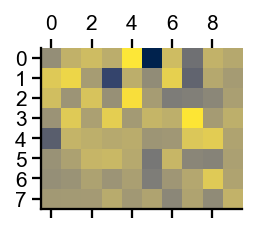

In [22]:
w1 = w1s2[-1].copy()
w2 = w2s2[-1].copy()

u, s, v = compact_svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))

fig, ax = plt.subplots()
ax.matshow(np.sqrt(s) @ v.T @ xs)

r1, sqrts1, v = compact_svd(w1)
u, sqrts2, r2 = compact_svd(w2)

print(np.diag(sqrts1))
print(np.diag(sqrts2))

w0 = (w2 @ w1).copy()

losses = []
w1s = []
w2s = []
for i in range(5000):
    losses.append(np.mean(w2 @ w1 @ xs @ xs.T - ys @ xs.T)**2)
    w1s.append(w1.copy())
    w2s.append(w2.copy())

    dw1 = w2.T + 2 * w1 # w1 + w2.T @ (w2 @ w1 - w0)
    dw2 = w1.T + w * w2 # w2 + (w2 @ w1 - w0) @ w1.T
    w1 -= 0.05 * dw1
    w2 -= 0.05 * dw2
    
r1, sqrts1, v = compact_svd(w1)
u, sqrts2, r2 = compact_svd(w2)

fig, ax = plt.subplots()
ax.matshow(np.sqrt(sqrts1) @ v.T @ xs)

fig, ax = plt.subplots()
ax.plot(losses)
ax.set_ylim(-0.01, 0.05)

In [26]:
xis = []

sigma = np.sqrt(1.2)

for i in range(10000):
    xi = np.random.normal(0., sigma, (5, 1))
    xis.append(xi @ xi.T)

print(np.round(np.mean(xis, axis=0), 3))

[[ 1.213  0.004  0.027 -0.007  0.013]
 [ 0.004  1.225  0.031  0.017 -0.011]
 [ 0.027  0.031  1.229 -0.002 -0.007]
 [-0.007  0.017 -0.002  1.199 -0.01 ]
 [ 0.013 -0.011 -0.007 -0.01   1.179]]


[2.80691672 2.64708296 2.45692321 1.9114284  1.83701254 1.80414465
 1.39442039 0.9872477  0.90906411 0.83657249]
[2.41125215 1.86655204 1.15171198 0.96001679 0.8715096  0.71446262
 0.44596504 0.38847935]


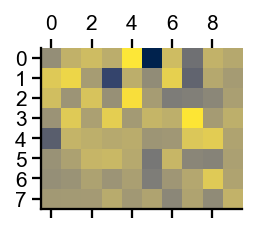

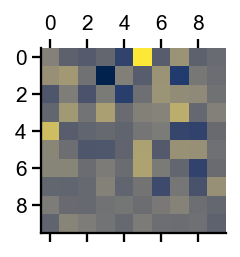

In [15]:
w1 = w1s2[-1].copy()
w2 = w2s2[-1].copy()

u, s, v = compact_svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))

fig, ax = plt.subplots()
ax.matshow(np.sqrt(s) @ v.T @ xs)

r1, sqrts1, v = compact_svd(w1)
u, sqrts2, r2 = compact_svd(w2)

print(np.diag(sqrts1))
print(np.diag(sqrts2))

losses = []
w1s = []
w2s = []
for i in range(5000):
    losses.append(np.mean(w2 @ w1 @ xs @ xs.T - ys @ xs.T)**2)
    w1s.append(w1.copy())
    w2s.append(w2.copy())
    d = w2.T @ w2 - w1 @ w1.T
    dw1 = -d @ w1
    dw2 = w2 @ d
    w1 -= 0.05 * dw1
    w2 -= 0.05 * dw2
    
r1, sqrts1, v = compact_svd(w1)
u, sqrts2, r2 = compact_svd(w2)

fig, ax = plt.subplots()
ax.matshow(np.sqrt(sqrts1) @ v.T @ xs)

(-0.01, 0.05)

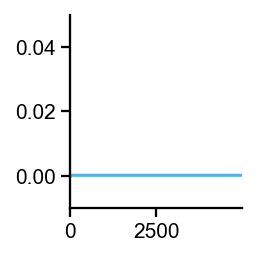

In [17]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_ylim(-0.01, 0.05)

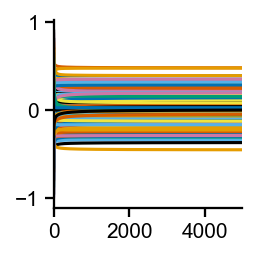

In [18]:
fig, ax = plt.subplots()
ax.plot(np.asarray(w1s).reshape(5000, -1));

In [28]:
u, s, v = compact_svd(w1)
print(np.sqrt(np.diag(s)))

[1.18754814 1.0850029  0.95265386 0.88212076 0.80609917 0.77074874
 0.72157112 0.56273669 0.20734993 0.20732738]


Text(0.5, 0, 'Diffusion Step')

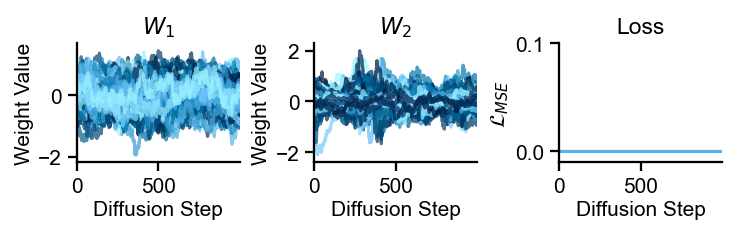

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(1.6*3, 1.45))
ax = axs[0]
ax.set_prop_cycle(cycler(color=blues))
ax.plot(w1s1.reshape(steps, -1), alpha=0.7)
#ax.set_ylim(-1.7, 1.7)
#ax.set_yticks([-1., 0, 1.])
ax.set_title("$W_1$")
ax.set_ylabel("Weight Value")
ax.set_xlabel("Diffusion Step")

ax = axs[1]
ax.set_prop_cycle(cycler(color=blues))
ax.plot(w2s1.reshape(steps, -1), alpha=0.7)
#ax.set_ylim(-2.8, 2.8)
ax.set_yticks([-2, 0, 2])
ax.set_title("$W_2$")
ax.set_ylabel("Weight Value")
ax.set_xlabel("Diffusion Step")

ax = axs[2]
ax.plot(np.mean(np.linalg.norm(np.einsum("abc,adb->adc", w1s1, w2s1) @ xs - ys, axis=1)**2, axis=1), c=colors[0])
ax.set_ylim(-0.01, 0.1)
ax.set_title("Loss")
ax.set_ylabel("$\mathcal{L}_{MSE}$")
ax.set_xlabel("Diffusion Step")

In [ ]:
# Diffusion on least squares solution manifold
np.random.seed(1)

alpha = 0.0125

u_, s_, v_ = np.linalg.svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))
g, _, _ = compact_svd(xs @ xs.T)
s__ = np.diag(np.concatenate([np.sqrt(s_), np.linalg.svd(np.random.normal(0., .3, (hidden_dim, in_dim)))[1][1:]]))

q = np.random.normal(0., .125, (hidden_dim, in_dim))
w2_null = np.random.normal(0., .5, (out_dim, hidden_dim))

w1s = []
w2s = []
hs = []
eta = 0.1
for i in range(steps*2 - 1):
    q = (1. - alpha) * q + alpha * np.random.normal(0., 3., q.shape)
    w1 = (q @ s__ @ v_) @ (g @ g.T)
    
    qinv = np.linalg.pinv(q)[[0], :]
    h, _, _ = compact_svd(w1 @ xs @ xs.T)
    w2_null = (1. - alpha) * w2_null + alpha * np.random.normal(0., 6., w2_null.shape)
    w2 = u_ @ np.sqrt(s_) @ qinv + w2_null @ (np.identity(h.shape[0]) - h @ h.T)
    
    if i >= steps - 1:
        w1s.append(w1)
        hs.append(w1 @ xs)
        w2s.append(w2)

w1s2 = np.asarray(w1s)
hs2 = np.asarray(hs)
w2s2 = np.asarray(w2s)

In [ ]:
# Diffusion on minimum-norm solution
np.random.seed(1)

alpha = 0.0125

u_, s_, v_ = compact_svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))
r_ = np.random.normal(0., 1., (hidden_dim, 1))

w1s = []
w2s = []
hs = []
eta = 0.1
for i in range(steps*2 - 1):
    r_ = (1. - alpha) * r_ + alpha * np.random.normal(0., 6., r_.shape)
    r = np.linalg.svd(r_, False)[0]
    w1 = r @ np.sqrt(s_) @ v_.T
    w2 = u_ @ np.sqrt(s_) @ r.T
    
    if i >= steps - 1:
        w1s.append(w1)
        hs.append(w1 @ xs)
        w2s.append(w2)

w1s3 = np.asarray(w1s)
hs3 = np.asarray(hs)
w2s3 = np.asarray(w2s)

In [28]:
def compact_svd(x):
    a, b, ct = np.linalg.svd(x, False)
    a = a[:, b > 1e-9]
    c = ct.T[:, b > 1e-9]
    b = np.diag(b[b>1e-9])
    return a, b, c

def random_orthogonal(in_dim, out_dim):
    max_dim = np.max([in_dim, out_dim])
    return scipy.stats.special_ortho_group.rvs(max_dim)[:out_dim, :in_dim]

In [47]:
xs = np.random.normal(0., 1., (3, 5))
ys = np.random.normal(0., 1., (1, 5))

u, s, v = compact_svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))
u, s, vt = np.linalg.svd(ys @ xs.T @ np.linalg.pinv(xs @ xs.T))


r = random_orthogonal(1, 7)

w1_ = r @ np.diag(np.sqrt(s)) @ vt[[0], :]
w2_ =  u @ np.diag(np.sqrt(s)) @ r.T

print(w2 @ w1 @ xs @ xs.T - ys @ xs.T)

r = random_orthogonal(2, 7)
w1 = r @ np.diag(np.stack([np.sqrt(s.item()), 0.5])) @ vt[[0, 1], :]
w2 = ys @ xs.T @ w1.T @ np.linalg.pinv(w1 @ xs @ xs.T @ w1.T)

print(w2 @ w1 @ xs @ xs.T - ys @ xs.T)

q = w1 @ np.linalg.pinv(w1_)

print(np.round(w1, 3))
print(np.round(q @ w1_, 3))

[[-0.84552416 -0.33132227 -5.29476651]]
[[-6.66133815e-16  3.33066907e-16 -1.77635684e-15]]
[[-0.303  0.263 -0.619]
 [-0.19   0.055 -0.339]
 [-0.203  0.286 -0.464]
 [ 0.207 -0.022  0.353]
 [-0.02  -0.069 -0.001]
 [ 0.167 -0.246  0.386]
 [ 0.147  0.43   0.051]]
[[-0.296  0.28  -0.615]
 [-0.153  0.144 -0.317]
 [-0.231  0.219 -0.48 ]
 [ 0.155 -0.147  0.321]
 [ 0.007 -0.007  0.015]
 [ 0.194 -0.183  0.402]
 [-0.025  0.024 -0.052]]


In [ ]:
w1 = r @ np.diag(np.stack([np.sqrt(s.item()), 0.5])) @ vt[[0, 1], :]
print(np.round(w1, 3))
w1 = r @ np.diag(np.stack([np.sqrt(s.item()), 0.5])) @ vt[[0, 1], :]

In [23]:
u.shape, s.shape, vt[0, :].shape

((1, 1), (1,), (3,))

# Training Data

In [12]:
def hot_cold_vector(n, idx1, idx2):
    x = np.zeros(n)
    x[idx1] = np.sqrt(0.5)
    x[idx2] = -np.sqrt(0.5)
    return x

# Joint training data
xs = []
ys = []
idxs1 = []
idxs2 = []
idx = 0
for i in range(12):
    for j in range(12):
        if i == j:
            continue
        if (np.abs(i-j) > 1) or (i in [5, 6] and j in [5, 6]):
            idxs1.append(idx)
        if i in [5, 6] and j in [5, 6]:
            idxs2.append(idx)
        xs.append(hot_cold_vector(12, i, j))
        ys.append([1. if i > j else -1.])
        idx += 1
xs = np.asarray(xs).T
ys = np.asarray(ys).T

sigxx = 1. / xs.shape[-1] * xs @ xs.T
sigyx = 1. / xs.shape[-1] * ys @ xs.T

# Phase 1
mask = [True if i not in idxs1 else False for i in range(xs.shape[-1])]
xs1 = xs[:, mask]
ys1 = ys[:, mask]

sigxx1 = 1. / xs1.shape[-1] * xs1 @ xs1.T
sigyx1 = 1. / xs1.shape[-1] * ys1 @ xs1.T

# Phase 2
mask = [True if i in idxs2 else False for i in range(xs.shape[-1])]
xs2 = xs[:, mask]
ys2 = ys[:, mask]

sigxx2 = 1. / xs2.shape[-1] * xs2 @ xs2.T
sigyx2 = 1. / xs2.shape[-1] * ys2 @ xs2.T

In [3]:
def compact_svd(x):
    a, b, ct = np.linalg.svd(x, False)
    a = a[:, b > 1e-9]
    c = ct.T[:, b > 1e-9]
    b = np.diag(b[b>1e-9])
    return a, b, c

def random_orthogonal(in_dim, out_dim):
    max_dim = np.max([in_dim, out_dim])
    return scipy.stats.special_ortho_group.rvs(max_dim)[:out_dim, :in_dim]

# Figure 1

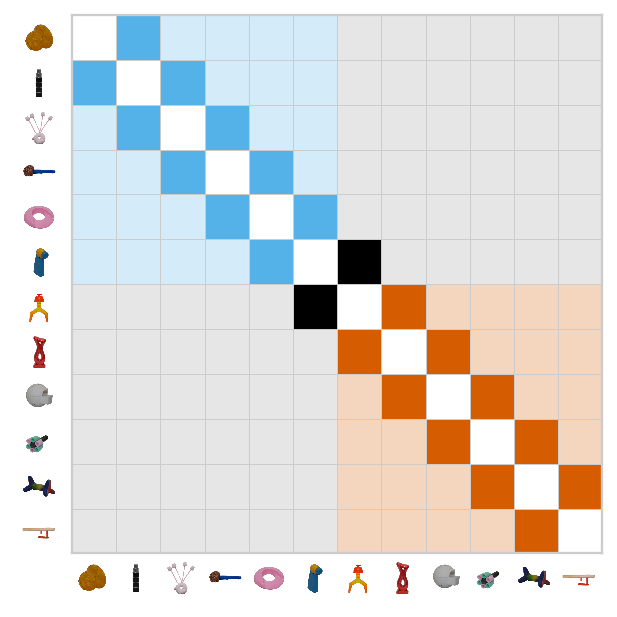

In [4]:
fig, ax = plt.subplots(figsize=(4., 4.), constrained_layout=True)

img = np.zeros((12, 12, 4))

for i in range(12):
    for j in range(12):
        if i == j:
            img[j, i] = (1., 1., 1., 1.)
        elif (np.abs(i-j) > 1):
            if i < 6 and j < 6:
                img[j, i] = matplotlib.colors.to_rgba(colors[0], alpha=0.25)
            elif i >= 6 and j >= 6:
                img[j, i] = matplotlib.colors.to_rgba(colors[4], alpha=0.25)
            else:
                img[j, i] = (0.9, 0.9, 0.9, 1.)
        elif i in [5, 6] and j in [5, 6]:
            img[j, i] = (0., 0., 0., 1.)
        else:
            if i < 6 and j < 6:
                img[j, i] = matplotlib.colors.to_rgba(colors[0])
            if i >= 6 and j >= 6:
                img[j, i] = matplotlib.colors.to_rgba(colors[4])

ax.pcolormesh(np.rot90(img), edgecolors=(0.8, 0.8, 0.8), linewidth=0.25)

imgs = [plt.imread(f"./noun-images/{i}.jpeg") for i in range(1, 13)]

ax.tick_params(axis='both', which='both', length=0, labelsize=8)
ax.set_xticks(range(12))
ax.set_xticklabels([""] * 12)
ax.set_yticks(range(12))
ax.set_yticklabels([""] * 12)

ax.spines[["left", "bottom", "top", "right"]].set_visible(True)
for spine in ax.spines.values():
    spine.set_edgecolor((0.8, 0.8, 0.8))

for x, y, labels in [(-0.1, 1.25, ax.xaxis.get_ticklabels()), (1.5, -0.15, ax.yaxis.get_ticklabels()[::-1])]:
    for i, img in enumerate(imgs):
        oi = OffsetImage(img, zoom=0.08)
        oi.image.axes = ax
        ab = AnnotationBbox(oi, labels[i].get_position(), frameon=False, box_alignment=(x, y))
        ax.add_artist(ab)

fig.savefig("./figures/figure-1-a.svg")

In [14]:
ys1 @ xs1.T @ np.linalg.pinv(xs1 @ xs1.T)

array([[-3.53553391, -2.12132034, -0.70710678,  0.70710678,  2.12132034,
         3.53553391, -3.53553391, -2.12132034, -0.70710678,  0.70710678,
         2.12132034,  3.53553391]])

In [15]:
ys1 @ xs1.T

array([[-1.41421356,  0.        ,  0.        ,  0.        ,  0.        ,
         1.41421356, -1.41421356,  0.        ,  0.        ,  0.        ,
         0.        ,  1.41421356]])

# Figure 2

In [ ]:
# plt.rcParams['text.usetex'] = False

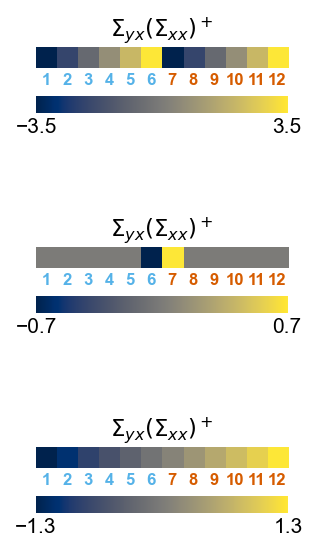

In [47]:
vmin = -3.5
vmax = 3.5

fig, axs = plt.subplots(3, 1, figsize=(2., 2. * 2.), constrained_layout=True)
axs = axs.flatten()
for i, (xs_, ys_) in enumerate([(xs1, ys1), (xs2, ys2), (xs, ys)]):
    bs = 1. / xs_.shape[-1]
    ax = axs[i]
    res = bs * ys_ @ xs_.T @ np.linalg.pinv(bs * xs_ @ xs_.T)
    vmin, vmax = np.round([np.min(res), np.max(res)], 1)
    cbax = ax.imshow(res)
    ax.set_title("$\Sigma_{yx}(\Sigma_{xx})^+$")
    ax.tick_params(axis='both', which='both', length=0, labelsize=8)
    ax.set_xticks(range(12))
    ax.set_xticklabels(range(1, 13))
    ax.set_yticks([])
    for j in range(12):
        ax.get_xticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_xticklabels()[j].set_fontweight('bold')
    ax.spines[["bottom", "left"]].set_visible(False)

    cb = fig.colorbar(cbax, shrink=1., aspect=15, pad=0.06, ax=axs[i], location="bottom")
    cb.outline.set_visible(False)
    cb.set_ticks([vmin, vmax])
    cb.ax.tick_params(length=0)
    # cb.set_label("a.u.", labelpad=-7., fontsize=10)
fig.savefig(f"./figures/figure-2-c.svg")

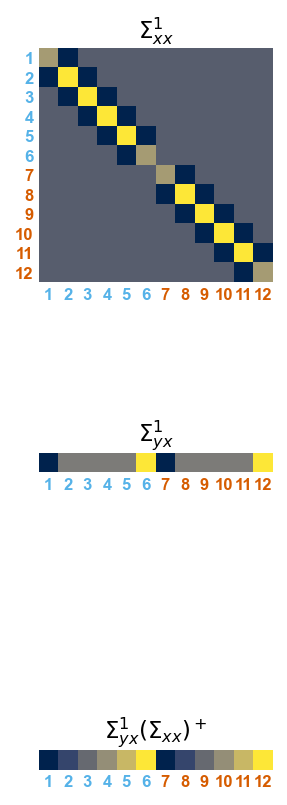

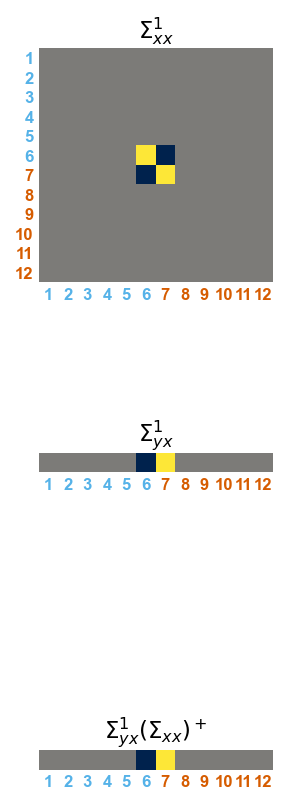

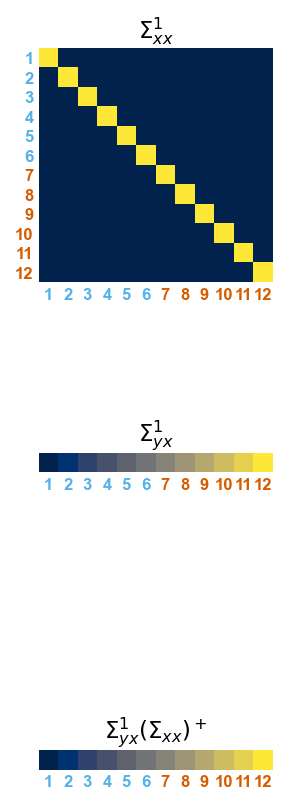

In [33]:
vmin = -3.5
vmax = 3.5

for i, (xs_, ys_) in enumerate([(xs1, ys1), (xs2, ys2), (xs, ys)]):
    fig, axs = plt.subplots(3, 1, figsize=(1.8, 2. * 3.), constrained_layout=True)
    axs = axs.flatten()

    bs = 1. / xs_.shape[-1]
    
    ax = axs[0]
    ax.imshow(bs * xs_ @ xs_.T)
    ax.set_title("$\Sigma_{xx}^1$")

    ax.tick_params(axis='both', which='both', length=0, labelsize=8)
    ax.set_xticks(range(12))
    ax.set_xticklabels(range(1, 13))
    ax.set_yticks(range(12))
    ax.set_yticklabels(range(1, 13))

    for j in range(12):
        ax.get_xticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_xticklabels()[j].set_fontweight('bold')
        ax.get_yticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_yticklabels()[j].set_fontweight('bold')
    ax.spines[["bottom", "left"]].set_visible(False)

    
    ax = axs[1]
    ax.imshow(bs * ys_ @ xs_.T)
    ax.set_title("$\Sigma_{yx}^1$")
    ax.tick_params(axis='both', which='both', length=0, labelsize=8)
    ax.set_xticks(range(12))
    ax.set_xticklabels(range(1, 13))
    ax.set_yticks([])
    for j in range(12):
        ax.get_xticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_xticklabels()[j].set_fontweight('bold')
    ax.spines[["bottom", "left"]].set_visible(False)
    
    ax = axs[2]
    ax.imshow(bs * ys_ @ xs_.T @ np.linalg.pinv(bs * xs_ @ xs_.T))
    ax.set_title("$\Sigma_{yx}^1(\Sigma_{xx})^+$")
    ax.tick_params(axis='both', which='both', length=0, labelsize=8)
    ax.set_xticks(range(12))
    ax.set_xticklabels(range(1, 13))
    ax.set_yticks([])
    for j in range(12):
        ax.get_xticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_xticklabels()[j].set_fontweight('bold')
    ax.spines[["bottom", "left"]].set_visible(False)
    
    fig.savefig(f"./figures/figure-2-c-{i}.svg")

# Figure 3

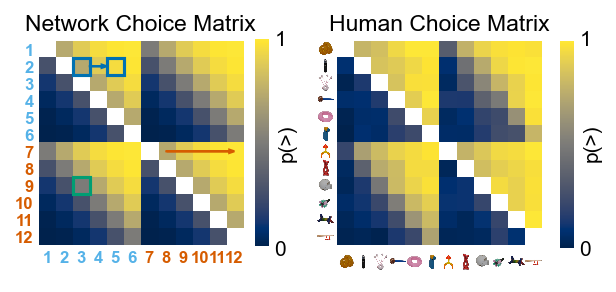

In [136]:
dat = np.loadtxt("./Midd.txt", delimiter=",")

fig, axs = plt.subplots(1, 2, figsize=(2.*2, 2.), constrained_layout=True)

out = np.zeros((12, 12))
idx = 0
for i in range(12):
    for j in range(12):
        if i == j:
            out[j, i] = np.nan
            continue
        out[j, i] = ((sigyx1 @ np.linalg.pinv(sigxx1)) @ xs[:, [idx]]).item()
        idx += 1

minimum_norm_out = 1. / (1. + np.exp(-out))

cbax1 = axs[0].imshow(minimum_norm_out)

axs[0].arrow(7., 6., 4., 0, length_includes_head=True, head_width=.2, color=colors[4], lw=1.)

axs[0].add_patch(plt.Rectangle((1.5, 0.5), 1, 1, fill=False, color=colors[5], linewidth=1.5, clip_on=False))
axs[0].add_patch(plt.Rectangle((3.5, 0.5), 1, 1, fill=False, color=colors[5], linewidth=1.5, clip_on=False))
axs[0].arrow(2.5, 1., 1., 0, length_includes_head=True, head_width=.2, color=colors[5])

#axs[0].add_patch(plt.Rectangle((5.5, -0.5), 6, 6, fill=False, color=colors[2], linewidth=1.5, clip_on=False))
#axs[0].add_patch(plt.Rectangle((-0.5, 5.5), 6, 6, fill=False, color=colors[2], linewidth=1.5, clip_on=False))

axs[0].add_patch(plt.Rectangle((1.5, 7.5), 1, 1, fill=False, color=colors[2], linewidth=1.5, clip_on=False))
#axs[0].add_patch(plt.Rectangle((4.5, 8.5), 1, 1, fill=False, color=colors[2], linewidth=1.5, clip_on=False))
#axs[0].arrow(5., 6.5, 0., 3., length_includes_head=True, head_width=.2, color=colors[2])
#axs[0].arrow(5., 6.5, 0., 3., length_includes_head=True, head_width=.2, color=colors[2])
        
axs[0].set_title("Network Choice Matrix")

cbax2 = axs[1].imshow(dat)

for i, cbax in enumerate([cbax1, cbax2]):
    cb = fig.colorbar(cbax, shrink=0.73, aspect=15, pad=0.06, ax=axs[i])
    cb.outline.set_visible(False)
    cb.set_ticks([0, 1])
    cb.ax.tick_params(length=0)
    cb.set_label("p(>)", labelpad=-4., fontsize=10)

axs[1].set_title("Human Choice Matrix")

for i in range(2):
    ax = axs[i]
    ax.tick_params(axis='both', which='both', length=0, labelsize=8)
    ax.set_xticks(range(12))
    ax.set_xticklabels(list(range(1, 13)))
    ax.set_yticks(range(12))
    ax.set_yticklabels(list(range(1, 13)))

    for j in range(12):
        ax.get_xticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_xticklabels()[j].set_fontweight('bold')
        ax.get_yticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_yticklabels()[j].set_fontweight('bold')
    ax.spines[["bottom", "left"]].set_visible(False)

ax = axs[1]
imgs = [plt.imread(f"./noun-images/{i}.jpeg") for i in range(1, 13)]

ax.set_xticks(range(12))
ax.set_xticklabels([""] * 12)
ax.set_yticks(range(12))
ax.set_yticklabels([""] * 12)

for x, y, labels in [(0.49, 13.25, ax.xaxis.get_ticklabels()), (1.75, 0.49, ax.yaxis.get_ticklabels())]:
    for i, img in enumerate(imgs):
        oi = OffsetImage(img, zoom=0.04)
        oi.image.axes = ax
        ab = AnnotationBbox(oi, labels[i].get_position(), frameon=False, box_alignment=(x, y))
        ax.add_artist(ab)

fig.savefig(f"./figures/figure-3-a-d.svg")

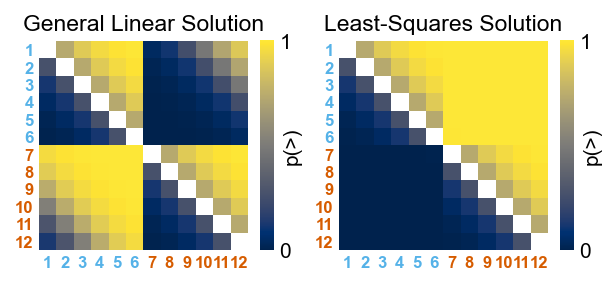

In [133]:
np.random.seed(1)

nh = 10
losses = []
w1_norms = []
w2_norms = []
w1w2_norms = []

u, s, v = compact_svd(sigyx1 @ np.linalg.pinv(sigxx1))
r = random_orthogonal(1, nh)
w1 = r @ np.sqrt(s) @ v.T
w2 = u @ np.sqrt(s) @ r.T

losses.append(np.linalg.norm(w2 @ w1 @ xs1 - ys1)**2)
w1_norms.append(np.linalg.norm(w1)**2)
w2_norms.append(np.linalg.norm(w2)**2)
w1w2_norms.append(np.linalg.norm(w2 @ w1)**2)

fig, axs = plt.subplots(1, 2, figsize=(2.*2, 2.), constrained_layout=True)
for k, (sd, sgd) in enumerate([(1, False), (5, True)]): # 2, 5
    np.random.seed(sd)
    w1 = np.random.uniform(-3., 3., (nh, 12))
    w2 = np.random.uniform(-2., 2., (1, nh))

    if sgd:
        loss = []
        for i in range(100000):
            w2 -= 0.1 * 1. / xs1.shape[-1] * (w2 @ w1 @ xs1 - ys1) @ xs1.T @ w1.T
            loss.append(1. / xs1.shape[-1] * np.linalg.norm(w2 @ w1 @ xs1 - ys1)**2)
    else:
        h = w1 @ xs1
        w2 = sigyx1 @ w1.T @ np.linalg.pinv(w1 @ sigxx1 @ w1.T)
        
    f = w2 @ w1

    losses.append(np.linalg.norm(w2 @ w1 @ xs1 - ys1)**2)
    w1_norms.append(np.linalg.norm(w1)**2)
    w2_norms.append(np.linalg.norm(w2)**2)
    w1w2_norms.append(np.linalg.norm(w2 @ w1)**2)
    
    out = np.zeros((12, 12))
    idx = 0
    for i in range(12):
        for j in range(12):
            if i == j:
                out[j, i] = np.nan
                continue
            out[j, i] = (f @ xs[:, [idx]]).item()
            idx += 1
    
    out = 1. / (1. + np.exp(-out))

    ax = axs[k]
    cbax = ax.imshow(out)

    cb = fig.colorbar(cbax, shrink=0.73, aspect=15, pad=0.06, ax=axs[k])
    cb.outline.set_visible(False)
    cb.set_ticks([0, 1])
    cb.ax.tick_params(length=0)
    cb.set_label("p(>)", labelpad=-4., fontsize=10)

    ax.tick_params(axis='both', which='both', length=0, labelsize=8)
    ax.set_xticks(range(12))
    ax.set_xticklabels(list(range(1, 13)))
    ax.set_yticks(range(12))
    ax.set_yticklabels(list(range(1, 13)))

    for j in range(12):
        ax.get_xticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_xticklabels()[j].set_fontweight('bold')
        ax.get_yticklabels()[j].set_color(colors[0 if j < 6 else 4])
        ax.get_yticklabels()[j].set_fontweight('bold')
    ax.spines[["bottom", "left"]].set_visible(False)
    

axs[0].set_title("General Linear Solution")
axs[1].set_title("Least-Squares Solution")
fig.savefig(f"./figures/figure-3-b-c.svg")

<BarContainer object of 3 artists>

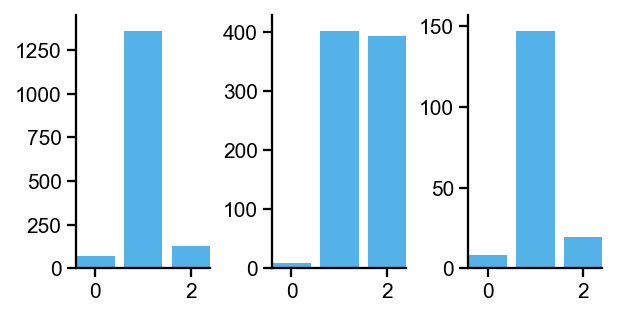

In [611]:
fig, axs = plt.subplots(1, 3, figsize=(2.*2, 2.), constrained_layout=True)
axs[0].bar(range(3), w1w2_norms)
axs[1].bar(range(3), w1_norms)
axs[2].bar(range(3), w2_norms)

In [140]:
network_out = minimum_norm_out[~np.isnan(minimum_norm_out)].flatten()
human_out = dat[~np.isnan(dat)].flatten()

pearsonr(network_out, human_out)

PearsonRResult(statistic=np.float64(0.9725428161524279), pvalue=np.float64(3.510704416107781e-84))

# Figure 4

Text(0, 0.5, 'Dim 2')

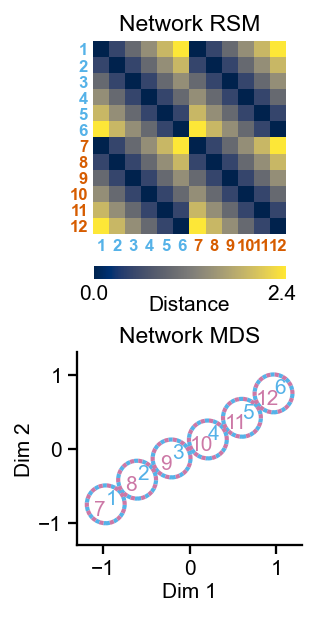

In [212]:
def rotate(xs, ys, angle):
    angle = angle * np.pi / 180.
    for i, (x, y) in enumerate(zip(xs, ys)):
        xs[i] = x * np.cos(angle) - y * np.sin(angle)
        ys[i] = x * np.sin(angle) + y * np.cos(angle)

u, s, v = compact_svd(sigyx1 @ np.linalg.pinv(sigxx1))
r = random_orthogonal(1, nh)
w1 = r @ np.sqrt(s) @ v.T
w2 = u @ np.sqrt(s) @ r.T

hs = []
for i in range(12):
    one_hot = np.zeros(12)
    one_hot[i] = 1.
    hs.append(w1 @ one_hot)
hs = np.asarray(hs).T

mds_nn = squareform(pdist(hs.T, metric='euclidean'))

fig, axs = plt.subplots(2, 1, figsize=(2, 4))
ax = axs[0]

cbax = ax.imshow(mds_nn)

cb = fig.colorbar(cbax, shrink=0.85, aspect=15, pad=0.06, ax=ax, location="bottom")
cb.outline.set_visible(False)
cb.set_ticks([0, np.round(np.max(mds_nn), 1)])
cb.ax.tick_params(length=0)
cb.set_label("Distance", labelpad=-4., fontsize=10)

ax.tick_params(axis='both', which='both', length=0, labelsize=8)
ax.set_xticks(range(12))
ax.set_xticklabels(list(range(1, 13)))
ax.set_yticks(range(12))
ax.set_yticklabels(list(range(1, 13)))

for j in range(12):
    ax.get_xticklabels()[j].set_color(colors[0 if j < 6 else 4])
    ax.get_xticklabels()[j].set_fontweight('bold')
    ax.get_yticklabels()[j].set_color(colors[0 if j < 6 else 4])
    ax.get_yticklabels()[j].set_fontweight('bold')
ax.spines[["bottom", "left"]].set_visible(False)


ax.set_title("Network RSM")

embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto', eps=1e-8, random_state=1)
h = embedding.fit_transform(mds_nn)

rotate(h[:, 0], h[:, 1], 30)

ax = axs[1]
for i in range(12):
    ls = (0, (1, 1)) if i < 6 else (1., (1, 1))
    ax.scatter(h[i, 0], h[i, 1], c=[(0., 0., 0., 0.)], edgecolors=[colors[0 if i < 6 else 1]], s=330, lw=2, ls=ls)
    offset = 0.07 if i < 6 else -0.07
    ax.text(h[i, 0] + offset, h[i, 1] + offset, i + 1, ha="center", va="center", c=colors[0 if i < 6 else 1])

    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
ax.set_title("Network MDS")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")

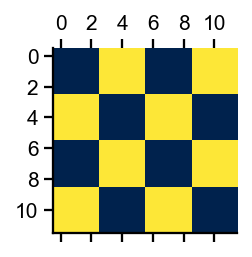

In [164]:
correlation_matrix = np.corrcoef(hs.T)
rdm_correlation = 1 - correlation_matrix

fig, ax = plt.subplots()
ax.matshow(rdm_correlation)

In [154]:
np.corrcoef(hs[0], hs[1])

array([[1., 1.],
       [1., 1.]])

In [155]:
hs[0] @ hs[1]

np.float64(0.8964214570007948)

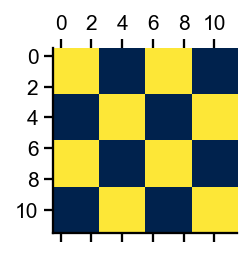

In [152]:
fig, ax = plt.subplots()
ax.matshow(np.corrcoef(hs))

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(0., 11., 12)
rv = scipy.stats.norm(scale=1., loc=3.)
ax.plot(x, rv.pdf(x))

In [ ]:
x = np.linspace(0., 11., 12)

xsts = []
for i in range(12):
    rv = scipy.stats.norm(scale=.5, loc=i)
    xsts.append(rv.pdf(x))
xsts = np.vstack(xsts)

print(xsts.shape)

fig, ax = plt.subplots()
ax.matshow(xsts)

In [ ]:
out = np.zeros((12, 12))
for i in range(12):
    for j in range(12):
        if i == j:
            continue
        if (np.abs(i-j) > 1) or (i in [5, 6] and j in [5, 6]):
            idxs.append(idx)
        xs.append(hot_cold_vector(12, i, j))
        ys.append([1. if i > j else -1.])
        idx += 1

fig, ax = plt.subplots()

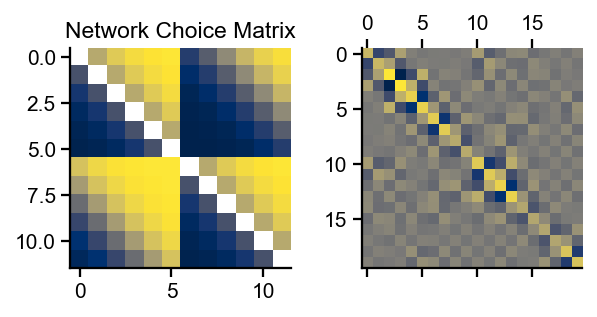

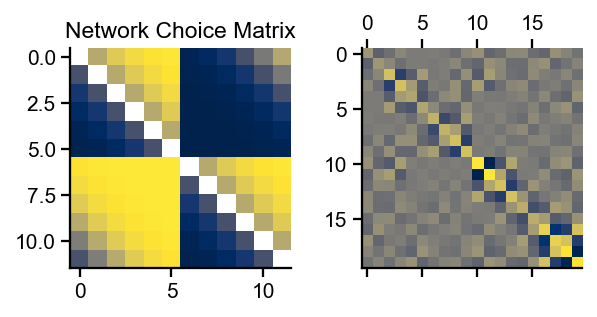

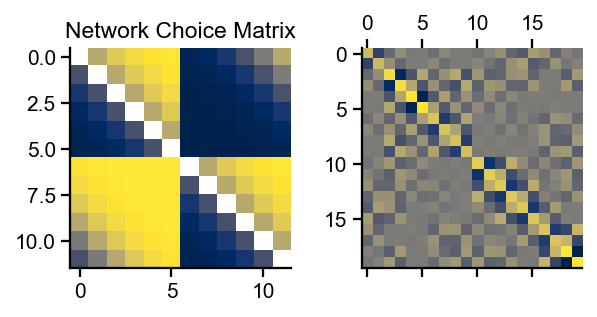

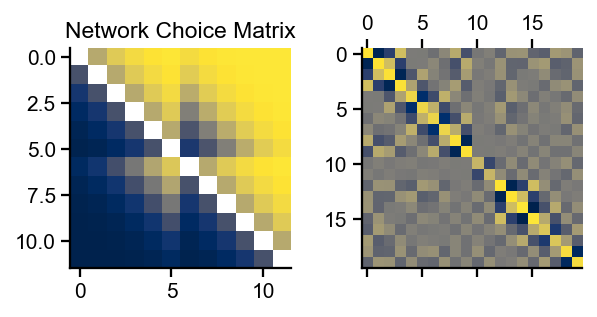

In [498]:
nh = 20

for sd in [1, 4, 6, 9]:
    
    np.random.seed(sd)
    w1 = np.random.uniform(-2., 2., (nh, 12))
    w2 = np.random.uniform(-3., 3., (1, nh))
    
    loss = []
    for i in range(50000):
        w2 -= 0.01 * 1. / xs1.shape[-1] * (w2 @ w1 @ xs1 - ys1) @ xs1.T @ w1.T
        loss.append(1. / xs1.shape[-1] * np.linalg.norm(w2 @ w1 @ xs1 - ys1)**2)
    
    #h = w1 @ xs1
    #w2 = sigyx1 @ w1.T @ np.linalg.pinv(w1 @ sigxx1 @ w1.T)
    f = w2 @ w1
    
    fig, axs = plt.subplots(1, 2, figsize=(2.*2, 2.), constrained_layout=True)
    
    out = np.zeros((12, 12))
    idx = 0
    for i in range(12):
        for j in range(12):
            if i == j:
                out[j, i] = np.nan
                continue
            out[j, i] = (f @ xs[:, [idx]]).item()
            idx += 1
    
    out = 1. / (1. + np.exp(-out))
    
    cbax1 = axs[0].imshow(out)
    axs[0].set_title("Network Choice Matrix")

    ax = axs[1]
    h = w1 @ xs1
    ax.matshow(h.T @ h)
    #embedding = MDS(n_components=2, normalized_stress='auto', eps=1e-8, random_state=1)
    #h = embedding.fit_transform(w1.T)

    #print(np.round(w2 @ w1 @ xs1, 4))
    
    #for i in range(12):
    #    ls = (0, (1, 1)) if i < 6 else (1., (1, 1))
    #    ax.scatter(h[i, 0], h[i, 1], c=[(0., 0., 0., 0.)], edgecolors=[colors[0 if i < 6 else 1]], s=200, lw=2, ls=ls)
        #ax.text(h[i, 0], h[i, 1], i, ha="center", va="center", c=colors[0 if i < 6 else 1])
    #ax.set_xlim(-1.5, 1.5)
    #ax.set_ylim(-1.5, 1.5)


In [482]:
w2 @ w1 @ xs1

array([[-0.89550742,  0.89550742, -0.87366762,  0.87366762, -0.97006601,
         0.97006601, -0.95103816,  0.95103816, -0.92108391,  0.92108391,
        -0.84104418,  0.84104418, -0.80079594,  0.80079594, -0.86175489,
         0.86175489, -0.81879289,  0.81879289, -0.98277486,  0.98277486]])

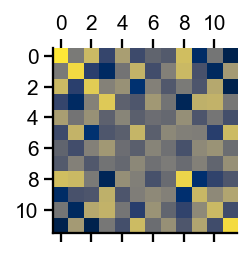

In [471]:
fig, ax = plt.subplots()
ax.matshow(h @ h.T)

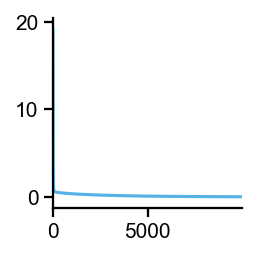

In [483]:
fig, ax = plt.subplots()
ax.plot(loss)

[[-1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.
  -1.  1.]]
[[-0.99999  0.99999 -0.99998  0.99998 -0.99998  0.99998 -0.99999  0.99999
  -0.99999  0.99999 -0.99999  0.99999 -0.99999  0.99999 -0.99999  0.99999
  -0.99999  0.99999 -1.       1.     ]]
[[-1.00001  1.00001 -1.00001  1.00001 -1.00001  1.00001 -1.00001  1.00001
  -1.       1.      -1.       1.      -1.00001  1.00001 -1.00001  1.00001
  -1.       1.      -1.       1.     ]]
[[-0.99998  0.99998 -0.99996  0.99996 -0.99996  0.99996 -0.99998  0.99998
  -0.99999  0.99999 -0.99999  0.99999 -0.99998  0.99998 -0.99998  0.99998
  -0.99998  0.99998 -0.99999  0.99999]]


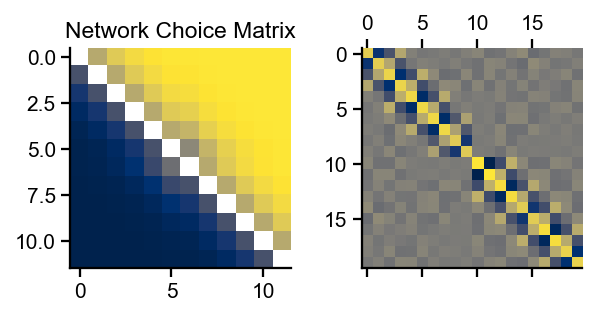

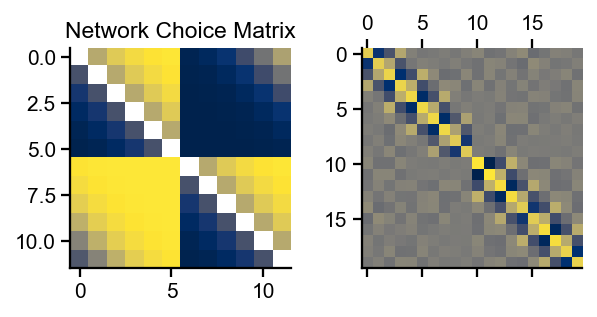

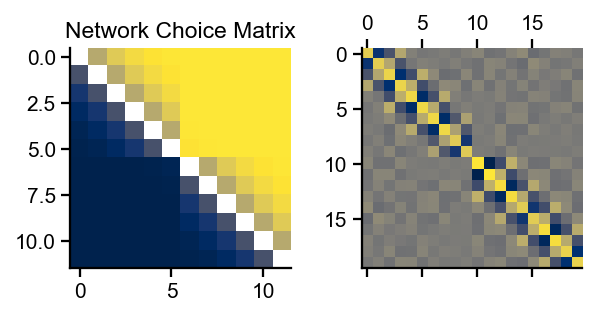

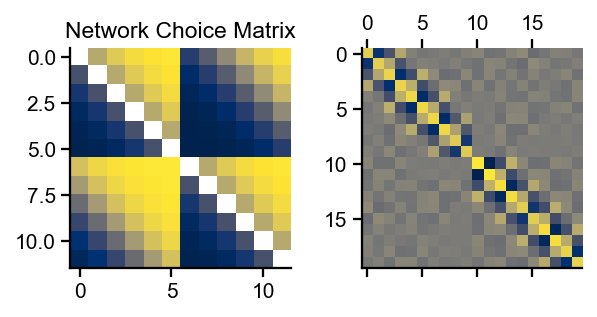

In [519]:
nh = 100

np.random.seed(1)
w1 = np.random.uniform(-2., 2., (nh, 12))

for sd in [1, 4, 6, 9]:
    
    w2 = np.random.uniform(-3., 3., (1, nh))
    
    loss = []
    for i in range(10000):
        w2 -= 0.001 * 1. / xs1.shape[-1] * (w2 @ w1 @ xs1 - ys1) @ xs1.T @ w1.T
        loss.append(1. / xs1.shape[-1] * np.linalg.norm(w2 @ w1 @ xs1 - ys1)**2)
    
    f = w2 @ w1

    print(np.round(w2 @ w1 @ xs1, 5))
    
    fig, axs = plt.subplots(1, 2, figsize=(2.*2, 2.), constrained_layout=True)
    
    out = np.zeros((12, 12))
    idx = 0
    for i in range(12):
        for j in range(12):
            if i == j:
                out[j, i] = np.nan
                continue
            out[j, i] = (f @ xs[:, [idx]]).item()
            idx += 1
    
    out = 1. / (1. + np.exp(-out))
    
    cbax1 = axs[0].imshow(out)
    axs[0].set_title("Network Choice Matrix")

    ax = axs[1]
    h = w1 @ xs1
    ax.matshow(h.T @ h)
    #embedding = MDS(n_components=2, normalized_stress='auto', eps=1e-8, random_state=1)
    #h = embedding.fit_transform(w1.T)
    
    #for i in range(12):
    #    ls = (0, (1, 1)) if i < 6 else (1., (1, 1))
    #    ax.scatter(h[i, 0], h[i, 1], c=[(0., 0., 0., 0.)], edgecolors=[colors[0 if i < 6 else 1]], s=200, lw=2, ls=ls)
        #ax.text(h[i, 0], h[i, 1], i, ha="center", va="center", c=colors[0 if i < 6 else 1])
    #ax.set_xlim(-1.5, 1.5)
    #ax.set_ylim(-1.5, 1.5)

Text(0.5, 1.0, 'Least-Squares Solution')

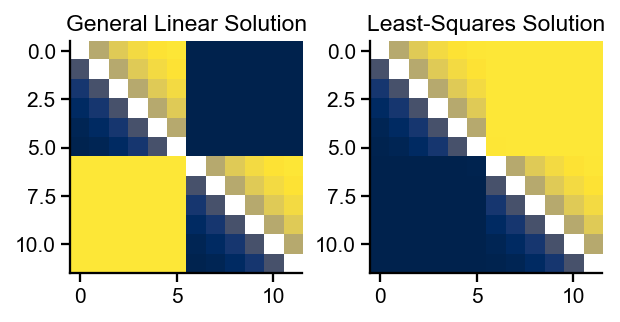

<BarContainer object of 2 artists>

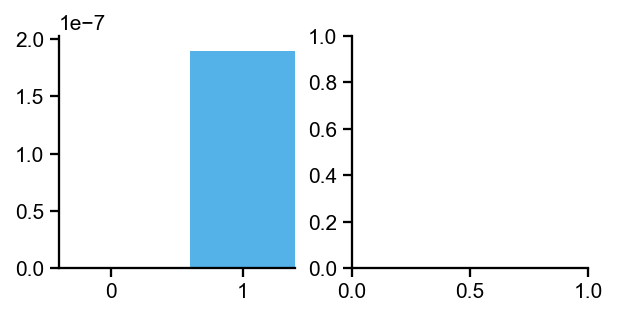

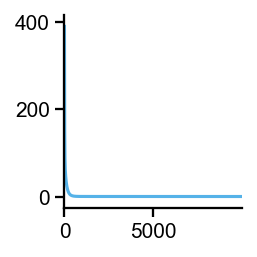

In [536]:
fig, ax = plt.subplots()
ax.plot(loss)

[[-1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1.
  -1.  1.]]


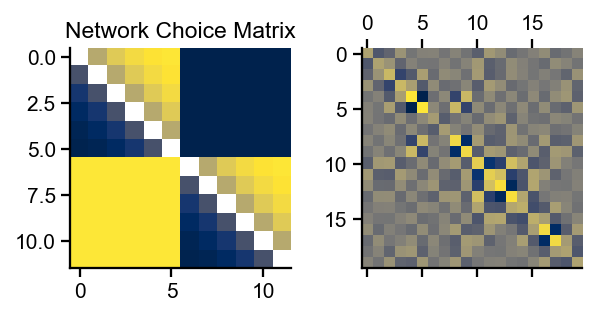

In [544]:
nh = 10

np.random.seed(1)

for sd in [2]:
    np.random.seed(sd)
    w1 = np.random.uniform(-12., 12., (nh, 12))
    
    h = w1 @ xs1
    w2 = sigyx1 @ w1.T @ np.linalg.pinv(w1 @ sigxx1 @ w1.T)
    f = w2 @ w1
    print(np.round(w2 @ w1 @ xs1, 5))
    fig, axs = plt.subplots(1, 2, figsize=(2.*2, 2.), constrained_layout=True)
    
    out = np.zeros((12, 12))
    idx = 0
    for i in range(12):
        for j in range(12):
            if i == j:
                out[j, i] = np.nan
                continue
            out[j, i] = (f @ xs[:, [idx]]).item()
            idx += 1
    
    out = 1. / (1. + np.exp(-out))
    
    cbax1 = axs[0].imshow(out)
    axs[0].set_title("Network Choice Matrix")

    ax = axs[1]
    h = w1 @ xs1
    ax.matshow(h.T @ h)
    #embedding = MDS(n_components=2, normalized_stress='auto', eps=1e-8, random_state=1)
    #h = embedding.fit_transform(w1.T)
    
    #for i in range(12):
    #    ls = (0, (1, 1)) if i < 6 else (1., (1, 1))
    #    ax.scatter(h[i, 0], h[i, 1], c=[(0., 0., 0., 0.)], edgecolors=[colors[0 if i < 6 else 1]], s=200, lw=2, ls=ls)
        #ax.text(h[i, 0], h[i, 1], i, ha="center", va="center", c=colors[0 if i < 6 else 1])
    #ax.set_xlim(-1.5, 1.5)
    #ax.set_ylim(-1.5, 1.5)

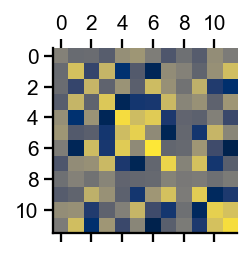

In [469]:
fig, ax = plt.subplots()
ax.matshow(h @ h.T)

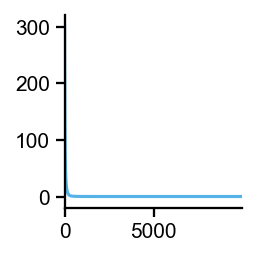

In [427]:
fig, ax = plt.subplots()
ax.plot(loss)

In [417]:
loss[-1]

np.float64(3.5950414379690096e-10)

In [418]:
(sigyx1 @ np.linalg.pinv(sigxx1)) @ xs1

array([[-1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
         1., -1.,  1., -1.,  1., -1.,  1.]])

In [479]:
w2 @ w1 @ xs1

array([[-0.32501609,  0.32501609,  0.12411428, -0.12411428,  0.22800251,
        -0.22800251, -0.13455809,  0.13455809, -0.0044944 ,  0.0044944 ,
         0.1680088 , -0.1680088 ,  0.1688831 , -0.1688831 , -0.21912692,
         0.21912692, -0.05752319,  0.05752319, -0.45015033,  0.45015033]])

In [ ]:
fig, ax = plt.subplots()
ax.scatter(0, 0, c="w", edgecolors=[colors[0 if i < 6 else 1]], s=200, lw=2, ls=(0, (1, 1)) if i < 6 else (1., (1, 1)))

/tmp/ipykernel_42900/3482049434.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(h[i, 0], h[i, 1], c=(0., 0., 0., 0.), edgecolors=[colors[0 if i < 6 else 1]], s=200, lw=2, ls=(0, (1, 1)) if i < 6 else (1., (1, 1)))


(-1.5, 1.5)

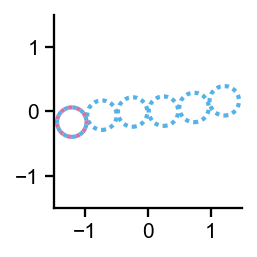

In [459]:
nh = 6
u, s, v = compact_svd(sigyx1 @ np.linalg.pinv(sigxx1))
r = random_orthogonal(1, nh)
w1 = r @ np.sqrt(s) @ v.T

fig, ax = plt.subplots()
embedding = MDS(n_components=2, normalized_stress='auto', eps=1e-8, random_state=1)
h = embedding.fit_transform(w1.T)

for i in range(12):
    ax.scatter(h[i, 0], h[i, 1], c=(0., 0., 0., 0.), edgecolors=[colors[0 if i < 6 else 1]], s=200, lw=2, ls=(0, (1, 1)) if i < 6 else (1., (1, 1)))
    if i > 5:
        break
    #ax.text(h[i, 0], h[i, 1], i, ha="center", va="center", c=colors[0 if i < 6 else 1])
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

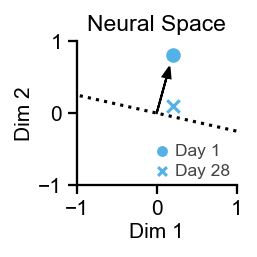

In [2]:
fig, ax = plt.subplots(figsize=(1.6, 1.6))

x, y = 0.2, 0.8
ax.scatter(x, y, marker="o", c=[colors[0]], label="Day 1")
ax.scatter(0.2, 0.1, marker="x", label="Day 28")
ax.arrow(0., 0., x * 0.8, y * 0.8, color="k", head_width=0.1, length_includes_head=True, zorder=1)

x_ = np.linspace(-3., 3., 1000)
y_ = (-x / y) * x_
ax.plot(x_, y_, linestyle=":", color="k", zorder=0)

ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)

ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_title("Neural Space")

ax.legend(loc="lower right")

plt.savefig("./figures/1/a.svg", dpi=300)

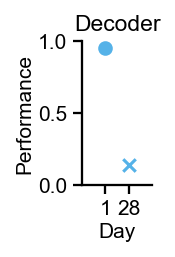

In [3]:
fig, ax = plt.subplots(figsize=(1., 1.6))

d1 = 0.95
d2 = 0.14

ax.scatter(1, d1, marker="o", color=colors[0])
ax.scatter(2, d2, marker="x", color=colors[0])

ax.set_xlim(0., 3.)
ax.set_ylim(0., 1.)

ax.set_xticks([1, 2])
ax.set_xticklabels([1, 28])
ax.set_xlabel("Day")
ax.set_ylabel("Performance")
ax.set_title("Decoder")

plt.savefig("./figures/1/b.svg", dpi=300)

In [4]:
class OdourTask(gs.datasets.Dataset):
    def __new__(cls, items_n=3, preprocessing=None):
        gs.environment.add_dataset(2)
        training_data = partial(cls.training_data, items_n=items_n)
        return super().__new__(cls, training_data, training_data, training_data)
    
    @staticmethod
    def training_data(rng_key, items_n):
        x = jnp.asarray([[
            [1., 0., 0.],
            [0., 1., 1.]
        ]]) * np.sqrt(2.)
        
        y = jnp.asarray([[
            [1., 0.1, .75]
        ]])
        
        return x, y

In [5]:
np.random.seed(22)
# np.random.seed(24)

def nullspace_vector(w2, norm):
    v = np.asarray([1., -w2[0, 0] / w2[0, 1]])
    return (v / np.linalg.norm(v)) * norm

items_n = 2
out_dim = 1
hidden_dim = 2

xs_, ys_ = OdourTask.training_data(None, None)
xs, ys = xs_[0, :, :items_n], ys_[0, :, :items_n]

u, s, vt = np.linalg.svd(1./2. * ys @ xs.T, False)

r2 = np.random.normal(0., 1., (out_dim, hidden_dim))
r1 = np.linalg.pinv(r2)

r2n = np.linalg.norm(r2)
r2 /= r2n
r1 *= r2n

w1 = r1 @ np.diag(np.sqrt(s)) @ vt
w2 = u @ np.diag(np.sqrt(s)) @ r2

w1[:, 0] += nullspace_vector(w2, 0.8)
w1[:, 1] -= nullspace_vector(w2, 0.7)

2023-11-14 12:56:29.394745: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-11-14 12:56:29.394814: E external/xla/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 525.125.6 does not match DSO version 525.147.5 -- cannot find working devices in this configuration
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
# Hyperparameters
hidden_dim = 2
items_n = 2
out_dim = 1
training_steps = 50
validation_steps = 10
learning_rate = 0.075

# Task and network
dataset = OdourTask()
task = gs.tasks.OnlineLearning(dataset, shuffle=False)
optimiser = gs.GradientDescent(learning_rate)
loss = gs.MeanSquaredError()

network = gs.Network([
    gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(w1)),
    gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(w2))
])

trainer = gs.Trainer(task, network, loss, optimiser)
state, params, train, validate, test = gs.assemble(trainer, root_seed=4)

# Training
total_steps = training_steps + validation_steps * 2
losses = np.zeros(total_steps)
outputs = np.zeros((total_steps, items_n))
w1s = np.zeros((total_steps, hidden_dim, items_n))
w2s = np.zeros((total_steps, 1, hidden_dim))

for step in range(total_steps):
    outputs[step] = params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"] @ xs
    w1s[step] = params["network"]["layer-0"]["w"]
    w2s[step] = params["network"]["layer-1"]["w"]
    
    if step > validation_steps and step < (validation_steps + training_steps):
        state["task"]["step"] = items_n + 1
        state, params, losses[step] = train(state, params)

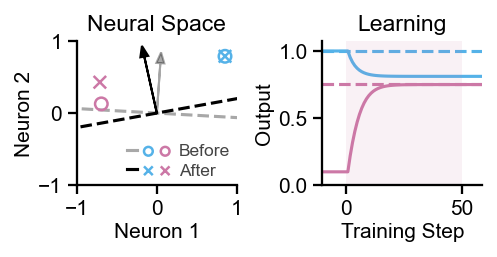

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(1.6*2, 1.6))

ax = axs[1]
ax.plot(outputs, zorder=1)
for i, y in enumerate(ys_[0, 0, [0, -1]]):
    ax.axhline(y*1.001, linestyle="--", c=colors[i], zorder=0)
ax.axvspan(10, 60, alpha=0.1, fc=colors[i], ec=None)
ax.set_ylim(0., 1.075)
ax.set_xticks([10., 60.])
ax.set_xticklabels([0, 50])
ax.set_xlabel("Training Step")
ax.set_ylabel("Output")
ax.set_title("Learning")

ax = axs[0]
refs = []
for t, m, a in zip([0, -1], ["o", "x"], [0.7, 1.]):
    ax.set_prop_cycle(None)
    refs.append(ax.plot(-5, 5, color="k", alpha=a**3)[0])
    for i in range(2):
        ref = ax.scatter(w1s[t, 0, i], w1s[t, 1, i], marker=m, ec=colors[i], fc='none', linewidths=1.2)
        refs.append(ref)
    ax.arrow(0., 0., w2s[t, 0, 0], w2s[t, 0, 1], length_includes_head=True, head_width=.1, color="k", alpha=a**3)
    x = np.linspace(-2, 2, 100)
    y = (-w2s[t, 0, 0] / w2s[t, 0, 1]) * x
    ax.plot(x, y, linestyle="--", alpha=a**3, zorder=0, c="k")
ax.set_xlim(-1., 1.)
ax.set_ylim(-1., 1.)
ax.set_xlabel("Neuron 1")
ax.set_ylabel("Neuron 2")
ax.set_title("Neural Space")

ax.legend([tuple(refs[:3]), tuple(refs[3:])], ['Before', 'After'], handlelength=2.5, handletextpad=0.5,
          handler_map={tuple: HandlerTuple(ndivide=None, pad=.4)}, loc="lower right")

plt.savefig("./figures/1/c-d.svg", dpi=300)

In [42]:
def nullspace_vector(w2, norm):
    v = np.asarray([1., -w2[0, 0] / w2[0, 1]])
    return (v / np.linalg.norm(v)) * norm

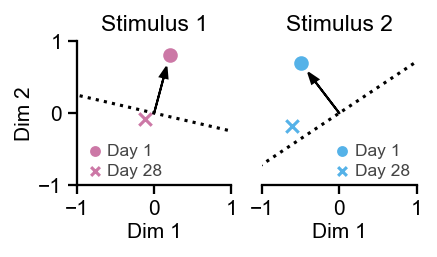

In [57]:
np.random.seed(1)

fig, axs = plt.subplots(1, 2, figsize=(1.4*2, 1.6))

for i, (x, y) in enumerate([(0.2, 0.8), (-0.5, 0.7)]):
    ax = axs[i]
    ax.scatter(x, y, marker="o", c=colors[i], label="Day 1")
    x_, y_ = nullspace_vector(np.asarray([[x, y]]), 0.5)
    jitter = np.random.uniform(-1.5, 1.5, 2)
    ax.scatter(x_ * jitter[0], y_ * jitter[1], marker="x", c=colors[i], label="Day 28")
    ax.arrow(0., 0., x * 0.8, y * 0.8, color="k", head_width=0.1, length_includes_head=True, zorder=1)
    
    x_ = np.linspace(-3., 3., 1000)
    y_ = (-x / y) * x_
    ax.plot(x_, y_, linestyle=":", color="k", zorder=0)

    ax.set_xlim(-1., 1.)
    ax.set_ylim(-1., 1.)
    
    if i == 1:
        ax.spines[['left']].set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    
    ax.set_xlabel("Dim 1")
    if i == 0:
        ax.set_title("Stimulus 1")
        ax.set_ylabel("Dim 2")
    else:
        ax.set_title("Stimulus 2")

    ax.legend()

In [3]:
class OdourTask(gs.datasets.Dataset):
    def __new__(cls, items_n=4, preprocessing=None):
        env.add_dataset(3)
        training_data = partial(cls.training_data, items_n=items_n)
        return super().__new__(cls, training_data, training_data, training_data)
    
    @staticmethod
    def training_data(rng_key, items_n):
        x = jnp.asarray([[
            [1., 0., 0., 0.],
            [0., 1., 0., 0.],
            [0., 0., 1., 1.]
        ]]) * np.sqrt(3.)
        
        y = jnp.asarray([[
            [.5, -0.1, 0., .4]
        ]])
        
        return x, y
    
    """
    @staticmethod
    def training_data(rng_key, items_n):
        x = jnp.asarray([[
            [1., 0., 0., 0., 1.],
            [0., 1., 0., 0., 0.],
            [0., 0., 1., 0., 0.],
            [0., 0., 0., 1., 0.]
        ]])
        
        y = jnp.asarray([[
            [1., 1., 1., 1., 1.],
            [0., 1., 0., 0., 1.],
            [0., 0., 1., 1., 0.],
            [1., 0., 0., 0., 1.],
            [0., 1., 0., 0., 0.],
            [0., 0., 1., 0., 0.],
            [0., 0., 0., 1., 0.]
        ]])
        
        return x, y
    """

In [4]:
np.random.seed(22)
# np.random.seed(24)

def nullspace_vector(w2, norm):
    v = np.asarray([1., -w2[0, 0] / w2[0, 1]])
    return (v / np.linalg.norm(v)) * norm

items_n = 3
out_dim = 1
hidden_dim = 2

xs_, ys_ = OdourTask.training_data(None, None)
xs, ys = xs_[0, :, :items_n], ys_[0, :, :items_n]

u, s, vt = np.linalg.svd(1./3. * ys @ xs.T, False)

r2 = np.random.normal(0., 1., (out_dim, hidden_dim))
r1 = np.linalg.pinv(r2)

r2n = np.linalg.norm(r2)
r2 /= r2n
r1 *= r2n


w1 = r1 @ np.diag(np.sqrt(s)) @ vt
w2 = u @ np.diag(np.sqrt(s)) @ r2

w1[:, 0] += nullspace_vector(w2, 0.7)
w1[:, 1] -= nullspace_vector(w2, 0.8)
w1[:, 2] -= nullspace_vector(w2, 0.4)

In [5]:
# Hyperparameters
hidden_dim = 2
items_n = 3
out_dim = 1
training_steps = 50
validation_steps = 10
learning_rate = 0.075

# Task and network
dataset = OdourTask()
task = gs.tasks.OnlineLearning(dataset, shuffle=False)
optimiser = gs.GradientDescent(learning_rate)
loss = gs.MeanSquaredError()

network = gs.Network([
    gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(w1)),
    gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(w2))
])

trainer = gs.Trainer(task, network, loss, optimiser)
state, params, train, validate, test = gs.assemble(trainer, root_seed=4)

# Training
total_steps = training_steps + validation_steps * 2
losses = np.zeros(total_steps)
outputs = np.zeros((total_steps, items_n))
w1s = np.zeros((total_steps, hidden_dim, items_n))
w2s = np.zeros((total_steps, 1, hidden_dim))

for step in range(total_steps):
    outputs[step] = params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"] @ xs
    w1s[step] = params["network"]["layer-0"]["w"]
    w2s[step] = params["network"]["layer-1"]["w"]
    
    if step > validation_steps and step < (validation_steps + training_steps):
        state["task"]["step"] = items_n + 1
        state, params, losses[step] = train(state, params)

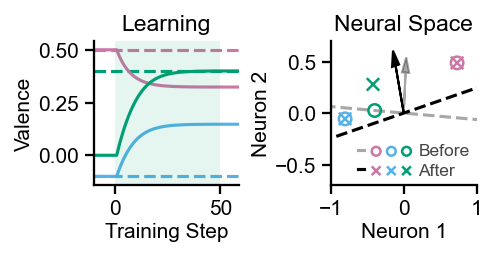

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(1.6*2, 1.6))

ax = axs[0]
ax.plot(outputs, zorder=1)
for i, y in enumerate(ys_[0, 0, [0, 1, -1]]):
    ax.axhline(y, linestyle="--", c=colors[i], zorder=0)
ax.axvspan(10, 60, alpha=0.1, fc=colors[2], ec=None)
ax.set_xticks([10., 60.])
ax.set_xticklabels([0, 50])
ax.set_xlabel("Training Step")
ax.set_ylabel("Valence")
ax.set_title("Learning")

ax = axs[1]
refs = []
for t, m, a in zip([0, -1], ["o", "x"], [0.7, 1.]):
    ax.set_prop_cycle(None)
    refs.append(ax.plot(-5, 5, color="k", alpha=a**3)[0])
    for i in range(3):
        ref = ax.scatter(w1s[t, 0, i], w1s[t, 1, i], marker=m, ec=colors[i], fc='none', linewidths=1.2)
        refs.append(ref)
    ax.arrow(0., 0., w2s[t, 0, 0], w2s[t, 0, 1], length_includes_head=True, head_width=.1, color="k", alpha=a**3)
    x = np.linspace(-2, 2, 100)
    y = (-w2s[t, 0, 0] / w2s[t, 0, 1]) * x
    ax.plot(x, y, linestyle="--", alpha=a**3, zorder=0, c="k")
ax.set_xlim(-1, 1)
ax.set_ylim(-.7, .7)
ax.set_xlabel("Neuron 1")
ax.set_ylabel("Neuron 2")
ax.set_title("Neural Space")

ax.legend([tuple(refs[:4]), tuple(refs[4:])], ['Before', 'After'], handlelength=3., handletextpad=0.5,
          handler_map={tuple: HandlerTuple(ndivide=None, pad=.5)}, loc="lower right")

In [114]:
# Hyperparameters
hidden_dim = 2
items_n = 3
out_dim = 1
pre_training_steps = 500
training_steps = 50
validation_steps = 10
learning_rate = 0.1

# Task and network
dataset = OdourTask()
task = gs.tasks.OnlineLearning(dataset, shuffle=False)
optimiser = gs.GradientDescent(learning_rate)
loss = gs.MeanSquaredError()

network = gs.Network([
    gs.Linear(hidden_dim, bias=False, weight_init=gs.init.Normal(std=0.001)),
    gs.Linear(out_dim, bias=False, weight_init=gs.init.Normal(std=0.001))
])

trainer = gs.Trainer(task, network, loss, optimiser)
state, params, train, validate, test = gs.assemble(trainer, root_seed=4)

# Training
total_steps = pre_training_steps + training_steps + validation_steps
validation_losses = np.zeros((total_steps, items_n))
outputs = np.zeros((total_steps, items_n))
w1s = np.zeros((total_steps, hidden_dim, items_n))
w2s = np.zeros((total_steps, 1, hidden_dim))

for step in range(total_steps):
    for item in range(items_n):
        _, validation_losses[step, item] = validate(state, params, idx=item)

    outputs[step] = params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]
    w1s[step] = params["network"]["layer-0"]["w"]
    w2s[step] = params["network"]["layer-1"]["w"]
    
    if step < pre_training_steps:
        state["task"]["step"] = np.random.randint(0, items_n)
    elif step < (pre_training_steps + training_steps):
        state["task"]["step"] = items_n + 1
    else:
        continue
    state, params, loss = train(state, params)

In [115]:
w2s.shape

(560, 1, 2)

NameError: name 'pre_training_steps' is not defined

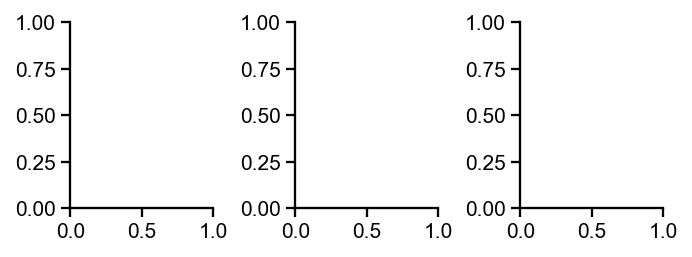

In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, axs = plt.subplots(1, 3, figsize=(1.5*3, 1.6))

ax = axs[0]
for i in range(3):
    ax.scatter(w1s[pre_training_steps, 0, i], w1s[pre_training_steps, 1, i])
ax.arrow(0., 0., w2s[pre_training_steps, 0, 0], w2s[pre_training_steps, 0, 1])
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel("Neuron 1")
ax.set_ylabel("Neuron 2")
ax.set_title("Before")

ax = axs[1]
ax.plot(outputs[490:])
#for i, y in enumerate([.8, 1., -0.2]):
#    ax.axhline(y, linestyle="--", c=colors[i])
ax.axvspan(10, 60, alpha=0.2)
ax.set_xticks([10., 60.])
ax.set_xticklabels([0, 50])
ax.set_xlabel("Training Step")
ax.set_ylabel("Valence")
ax.set_title("Learning")

ax = axs[2]
for i in range(3):
    ax.scatter(w1s[-1, 0, i], w1s[-1, 1, i])
ax.arrow(0., 0., w2s[-1, 0, 0], w2s[-1, 0, 1])
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel("Neuron 1")
ax.set_ylabel("Neuron 2")
ax.set_title("After")

In [6]:
ax._get_lines.prop_cycler.

(-0.5, 7.5)

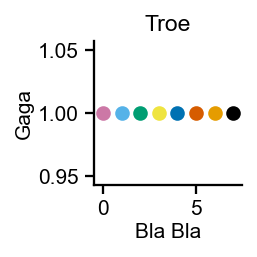

In [7]:
fig, ax = plt.subplots()
for i in range(8):
    ax.scatter(i, 1)

ax.set_title("Troe")
ax.set_xlabel("Bla Bla")
ax.set_ylabel("Gaga")
ax.set_xlim(-0.5, 7.5)

In [32]:

vline_color

'#d65c00'

In [ ]:
fig, ax = plt.subplots()
ax.plot(outputs[490:])
ax.set_xticks([10., 60.])
ax.set_xticklabels([0, 50])
ax.axvspan(10, 60, alpha=0.2)
ax.set_ylabel("Valence")
ax.set_xlabel("Training Step")
ax.set_title("Learning")

In [31]:
Smells
Valence
Stimulus
Plastic
Floral
Fresh
Spicy

-> Smells
Glove
Nerol
Octanal
Anisol

SyntaxError: invalid syntax (4031638327.py, line 7)

In [35]:
train._fun.keywords["task"].keywords["dataset"].keywords["data"]

(Array([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], dtype=float32),
 Array([[[[1., 1., 1., 1.],
          [0., 1., 0., 0.],
          [0., 0., 1., 1.],
          [1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]]]], dtype=float32))

In [37]:
train._fun.keywords["task"].keywords["dataset"].keywords["data"][1][0, 0, 1, 0] = 1

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

Array([[ 0.42      ,  0.89      ,  0.94      ,  1.        ,  0.45      ],
       [ 0.16      ,  1.3       ,  0.26      ,  1.        ,  0.19999999],
       [-0.14999999, -0.22999999,  0.78999996,  0.        , -0.13      ],
       [ 0.65      ,  0.25      ,  0.22999999,  1.        ,  0.65      ],
       [-0.09      ,  0.87      , -0.08      ,  0.        , -0.08      ],
       [ 0.04      ,  0.07      ,  1.04      , -0.        ,  0.05      ],
       [-0.17999999, -0.29999998, -0.25      ,  0.        , -0.17999999]],      dtype=float32)